### Spark notebook ###

This notebook will only work in a Jupyter notebook or Jupyter lab session running on the cluster master node in the cloud.

Follow the instructions on the computing resources page to start a cluster and open this notebook.

**Steps**

1. Connect to the Windows server using Windows App.
2. Connect to Kubernetes.
3. Start Jupyter and open this notebook from Jupyter in order to connect to Spark.

In [81]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Constants used to interact with Azure Blob Storage using the hdfs command or Spark

global username

username = re.sub('@.*', '', getpass.getuser())

global azure_account_name
global azure_data_container_name
global azure_user_container_name
global azure_user_token

azure_account_name = "madsstorage002"
azure_data_container_name = "campus-data"
azure_user_container_name = "campus-user"
azure_user_token = r"sp=racwdl&st=2025-08-01T09:41:33Z&se=2026-12-30T16:56:33Z&spr=https&sv=2024-11-04&sr=c&sig=GzR1hq7EJ0lRHj92oDO1MBNjkc602nrpfB5H8Cl7FFY%3D"


# Functions used below

def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")

        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://localhost:{sc.uiWebUrl.split(":")[-1]}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username} (notebook)</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{username}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.driver.memory", f'{master_memory}g')
        .config("spark.executor.memory", f'{worker_memory}g')
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.kubernetes.container.image", "madsregistry001.azurecr.io/hadoop-spark:v3.3.5-openjdk-8")
        .config("spark.kubernetes.container.image.pullPolicy", "IfNotPresent")
        .config("spark.kubernetes.memoryOverheadFactor", "0.3")
        .config("spark.memory.fraction", "0.1")
        .config(f"fs.azure.sas.{azure_user_container_name}.{azure_account_name}.blob.core.windows.net",  azure_user_token)
        .config("spark.app.name", f"{username} (notebook)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

### Assignment 2 ###

The code below demonstrates how to explore and load the data provided for the assignment from Azure Blob Storage and how to save any outputs that you generate to a separate user container.

**Key points**

- The data provided for the assignment is stored in Azure Blob Storage and outputs that you generate will be stored in Azure Blob Storage as well. Hadoop and Spark can both interact with Azure Blob Storage similar to how they interact with HDFS, but where the replication and distribution is handled by Azure instead. This makes it possible to read or write data in Azure over HTTPS where the path is prefixed by `wasbs://`.
- There are two containers, one for the data which is read only and one for any outputs that you generate,
  - `wasbs://campus-data@madsstorage002.blob.core.windows.net/`
  - `wasbs://campus-user@madsstorage002.blob.core.windows.net/`
- You can use variable interpolation to insert your global username variable into paths automatically.
  - This works for bash commands as well.

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=3, executor_cores=2, worker_memory=6, master_memory=6)

25/10/24 12:19:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [82]:
# Write your imports here or insert cells below

from pyspark.sql import functions as F
from pyspark.sql.types import *

In [83]:
# Decide resonable number of partitions
conf = sc.getConf()
N = int(conf.get("spark.executor.instances"))
M = int(conf.get("spark.executor.cores"))
partitions = 4 * N * M

print(f'ideal # partitions = {partitions}')

ideal # partitions = 24


In [84]:
# Helper functions

def show_class_balance(data, name="data", labelCol="label"):
    """Helper function to show class balance based on label.
    
    Note that this function does not return anything.

    Args:
        data (pyspark.sql.DataFrame): datafame with label
        name (str): name to print above metrics for readability 
        labelCol (str): label column name
    """

    total = data.count()
    counts = data.groupBy(labelCol).count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'Class balance [{name}]')
    print(f'')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

    
def with_custom_prediction(
    pred,
    threshold,
    probabilityCol="probability",
    customPredictionCol="customPrediction",
):
    """Helper function to select a custom prediction column for a custom classification threshold.
    
    Args:
        pred (pyspark.sql.DataFrame): datafame with column for probability 
        threshold (float): classification threshold
        probabilityCol (str): probability column name
        customPredictionCol (str): new custom prediction column name
    
    Returns:
        pred (pyspark.sql.DataFrame): dataframe with new colum for custom prediction
    """

    classification_udf = F.udf(lambda x: int(x[1] > threshold), IntegerType())
    
    return pred.withColumn(customPredictionCol, classification_udf(F.col(probabilityCol)))


def show_metrics(
    pred,
    name="data",
    threshold=0.5,
    labelCol="label",
    predictionCol="prediction",
    rawPredictionCol="rawPrediction",
    probabilityCol="probability",
):
    """Helper function to evaluate and show metrics based on a custom classification threshold.
    
    Note that this function does not return anything.
    
    Args:
        pred (pyspark.sql.DataFrame): datafame with column for probability 
        name (str): name to print above metrics for readability 
        threshold (float): classification threshold (default: 0.5)
        predictionCol (str): prediction column name
        rawPredictionCol (str): raw prediction column name
        probabilityCol (str): probability column name
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(
        rawPredictionCol=rawPredictionCol,
        labelCol=labelCol,
        metricName='areaUnderROC',
    )
    auroc = binary_evaluator.evaluate(pred)

    print(f'Metrics [{name}]')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')


def expand(x, s=0.05, d=0):
    """Expand a two element array about its center point by a relative scale or a fixed offset.
    Args:
        x (list|np.array): two element array
        s (float): relative scale to expand array based on its width x[1] - x[0]
        d (float): fixed offset to expand array
    Returns:
        x (np.array): expanded two element array
    """
    
    x = np.array(x)
    d = d + s * (x[1] - x[0])
    
    return x + np.array([-d, d])

## Processing

 Q1)

In [5]:
# Use the hdfs command to explore the data in Azure Blob Storage

!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/
#!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/ghcnd/daily/

Found 4 items
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/genre
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/main
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/tasteprofile


In [5]:
!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/main/

Found 2 items
-rwxrwxrwx   1   58658141 2025-02-18 15:22 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/main/analysis.csv.gz
-rwxrwxrwx   1  124211304 2025-02-18 15:22 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/main/metadata.csv.gz


In [6]:
!hdfs dfs -du -h wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/main/

55.9 M   55.9 M   wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/main/analysis.csv.gz
118.5 M  118.5 M  wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/main/metadata.csv.gz


In [7]:
!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/genre

Found 3 items
-rwxrwxrwx   1   11625230 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/genre/msd-MAGD-genreAssignment.tsv
-rwxrwxrwx   1    8820054 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/genre/msd-MASD-styleAssignment.tsv
-rwxrwxrwx   1   11140605 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/genre/msd-topMAGD-genreAssignment.tsv


In [8]:
!hdfs dfs -du -h wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/genre

8.4 M   8.4 M   wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/genre/msd-MASD-styleAssignment.tsv
10.6 M  10.6 M  wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/genre/msd-topMAGD-genreAssignment.tsv
11.1 M  11.1 M  wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/genre/msd-MAGD-genreAssignment.tsv


In [9]:
!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/audio/attributes

Found 13 items
-rwxrwxrwx   1       1051 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
-rwxrwxrwx   1        671 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
-rwxrwxrwx   1        484 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
-rwxrwxrwx   1        898 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
-rwxrwxrwx   1        777 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
-rwxrwxrwx   1        777 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all

In [10]:
!hdfs dfs -du -h wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/audio/attributes

9.8 K   9.8 K   wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-trh-v1.0.attributes.csv
777     777     wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv
777     777     wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
12.0 K  12.0 K  wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-marsyas-timbral-v1.0.attributes.csv
484     484     wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
3.8 K   3.8 K   wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-ssd-v1.0.attributes.csv
9.8 K   9.8 K   wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-mvd-v1.0.attributes.csv
1.4 K   1.4 K   wasbs://campus-data@madsstorage002.blob.core.w

In [11]:
!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/audio/features

Found 13 items
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-lpc-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus

In [12]:
!hdfs dfs -du -h wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/audio/features


65.5 M   65.5 M   wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv
3.9 G    3.9 G    wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-tssd-v1.0.csv
640.6 M  640.6 M  wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-ssd-v1.0.csv
412.2 M  412.2 M  wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-marsyas-timbral-v1.0.csv
240.3 M  240.3 M  wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-rh-v1.0.csv
51.1 M   51.1 M   wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv
51.1 M   51.1 M   wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv
1.4 G    1.4 G    wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-trh-v1.0.csv
53.1 M   53.1 M   wasbs://campu

In [13]:
!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/tasteprofile

Found 2 items
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/tasteprofile/mismatches
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/tasteprofile/triplets.tsv


In [14]:
!hdfs dfs -du -h wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/tasteprofile

488.4 M  488.4 M  wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/tasteprofile/triplets.tsv
2.0 M    2.0 M    wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/tasteprofile/mismatches


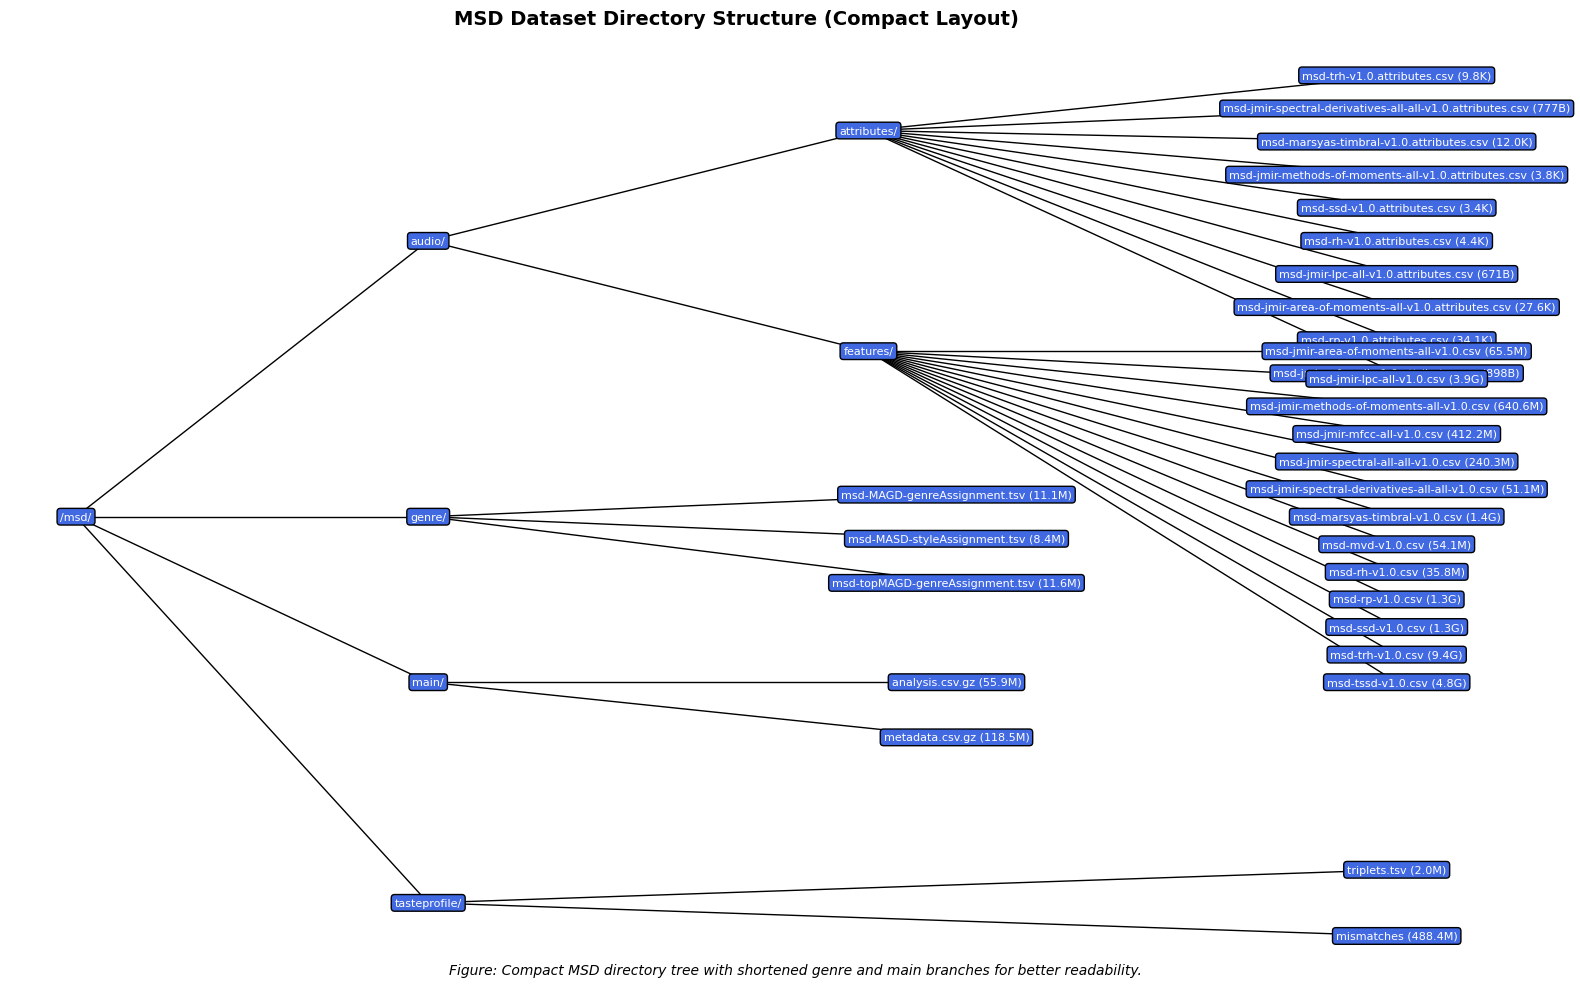

In [5]:
import matplotlib.pyplot as plt

# DATA
main_files = [
    ("analysis.csv.gz", "55.9M"),
    ("metadata.csv.gz", "118.5M")
]

genre_files = [
    ("msd-MAGD-genreAssignment.tsv", "11.1M"),
    ("msd-MASD-styleAssignment.tsv", "8.4M"),
    ("msd-topMAGD-genreAssignment.tsv", "11.6M")
]

tasteprofile_files = [
    ("triplets.tsv", "2.0M"),
    ("mismatches", "488.4M")
]

attributes_files = [
    ("msd-trh-v1.0.attributes.csv", "9.8K"),
    ("msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv", "777B"),
    ("msd-marsyas-timbral-v1.0.attributes.csv", "12.0K"),
    ("msd-jmir-methods-of-moments-all-v1.0.attributes.csv", "3.8K"),
    ("msd-ssd-v1.0.attributes.csv", "3.4K"),
    ("msd-rh-v1.0.attributes.csv", "4.4K"),
    ("msd-jmir-lpc-all-v1.0.attributes.csv", "671B"),
    ("msd-jmir-area-of-moments-all-v1.0.attributes.csv", "27.6K"),
    ("msd-rp-v1.0.attributes.csv", "34.1K"),
    ("msd-jmir-mfcc-all-v1.0.attributes.csv", "898B")
]

features_files = [
    ("msd-jmir-area-of-moments-all-v1.0.csv", "65.5M"),
    ("msd-jmir-lpc-all-v1.0.csv", "3.9G"),
    ("msd-jmir-methods-of-moments-all-v1.0.csv", "640.6M"),
    ("msd-jmir-mfcc-all-v1.0.csv", "412.2M"),
    ("msd-jmir-spectral-all-all-v1.0.csv", "240.3M"),
    ("msd-jmir-spectral-derivatives-all-all-v1.0.csv", "51.1M"),
    ("msd-marsyas-timbral-v1.0.csv", "1.4G"),
    ("msd-mvd-v1.0.csv", "54.1M"),
    ("msd-rh-v1.0.csv", "35.8M"),
    ("msd-rp-v1.0.csv", "1.3G"),
    ("msd-ssd-v1.0.csv", "1.3G"),
    ("msd-trh-v1.0.csv", "9.4G"),
    ("msd-tssd-v1.0.csv", "4.8G")
]

# COORDINATES 
coords = {
    "/msd/": (0.05, 0.5),
    "audio/": (0.25, 0.75),
    "genre/": (0.25, 0.5),
    "main/": (0.25, 0.35),
    "tasteprofile/": (0.25, 0.15),
    "attributes/": (0.5, 0.85),
    "features/": (0.5, 0.65)
}

# Add attribute and feature files (keep long for better readability)
for i, (f, s) in enumerate(attributes_files):
    coords[f"{f} ({s})"] = (0.8, 0.9 - i * 0.03)
for i, (f, s) in enumerate(features_files):
    coords[f"{f} ({s})"] = (0.8, 0.65 - i * 0.025)

# Add genre, main, and tasteprofile files — now shortened
for i, (f, s) in enumerate(genre_files):
    coords[f"{f} ({s})"] = (0.55, 0.52 - i * 0.04)
for i, (f, s) in enumerate(main_files):
    coords[f"{f} ({s})"] = (0.55, 0.35 - i * 0.05)
for i, (f, s) in enumerate(tasteprofile_files):
    coords[f"{f} ({s})"] = (0.8, 0.18 - i * 0.06)

# EDGES
edges = [
    ("/msd/", "audio/"),
    ("/msd/", "genre/"),
    ("/msd/", "main/"),
    ("/msd/", "tasteprofile/"),
    ("audio/", "attributes/"),
    ("audio/", "features/")
]
edges += [("attributes/", f"{f} ({s})") for f, s in attributes_files]
edges += [("features/", f"{f} ({s})") for f, s in features_files]
edges += [("genre/", f"{f} ({s})") for f, s in genre_files]
edges += [("main/", f"{f} ({s})") for f, s in main_files]
edges += [("tasteprofile/", f"{f} ({s})") for f, s in tasteprofile_files]

# PLOT
plt.figure(figsize=(16, 10))
for node, (x, y) in coords.items():
    plt.text(
        x, y, node, ha="center", va="center", fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="royalblue", edgecolor="black"),
        color="white"
    )

# Draw edges
for parent, child in edges:
    if parent in coords and child in coords:
        x0, y0 = coords[parent]
        x1, y1 = coords[child]
        plt.plot([x0, x1], [y0, y1], "k-", linewidth=1)

plt.axis("off")
plt.title("MSD Dataset Directory Structure (Compact Layout)", fontsize=14, weight="bold")
plt.figtext(
    0.5, 0.02,
    "Figure: Compact MSD directory tree with shortened genre and main branches for better readability.",
    ha="center", fontsize=10, style="italic"
)
plt.tight_layout()
plt.show()


In [6]:
# Load a subset into Spark from Azure Blob Storage using spark.read.csv

meta_data = spark.read.csv(
    path=f'wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net//msd/main/metadata.csv.gz',
    header=True,inferSchema = True
)

print(type(meta_data))
#daily.printSchema()
print(meta_data)
meta_data.show(20, False)

<class 'pyspark.sql.dataframe.DataFrame'>
DataFrame[analyzer_version: string, artist_7digitalid: int, artist_familiarity: double, artist_hotttnesss: double, artist_id: string, artist_latitude: double, artist_location: string, artist_longitude: string, artist_mbid: string, artist_name: string, artist_playmeid: string, genre: string, idx_artist_terms: int, idx_similar_artists: int, release: string, release_7digitalid: int, song_hotttnesss: string, song_id: string, title: string, track_7digitalid: string]
+----------------+-----------------+-------------------+-------------------+------------------+---------------+------------------------------+----------------+------------------------------------+----------------------------------------------+---------------+-----+----------------+-------------------+--------------------------------------+------------------+-------------------+------------------+------------------------------------------------------------------+----------------+
|analyze

In [7]:
analysis_data = spark.read.csv(
    path=f'wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net//msd/main/analysis.csv.gz',
    header=True,inferSchema = True
)

print(type(analysis_data))
#daily.printSchema()
print(analysis_data)
analysis_data.show(20, False)

25/10/24 12:21:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


<class 'pyspark.sql.dataframe.DataFrame'>
DataFrame[analysis_sample_rate: int, audio_md5: string, danceability: double, duration: double, end_of_fade_in: double, energy: double, idx_bars_confidence: int, idx_bars_start: int, idx_beats_confidence: int, idx_beats_start: int, idx_sections_confidence: int, idx_sections_start: int, idx_segments_confidence: int, idx_segments_loudness_max: int, idx_segments_loudness_max_time: int, idx_segments_loudness_start: int, idx_segments_pitches: int, idx_segments_start: int, idx_segments_timbre: int, idx_tatums_confidence: int, idx_tatums_start: int, key: int, key_confidence: double, loudness: double, mode: int, mode_confidence: double, start_of_fade_out: double, tempo: double, time_signature: int, time_signature_confidence: double, track_id: string]
+--------------------+--------------------------------+------------+---------+--------------+------+-------------------+--------------+--------------------+---------------+-----------------------+---------

In [8]:
# Read all TSV files from the genre directory at once
genre_all = spark.read.csv(
    path=f"wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/genre/*.tsv",
    sep="\t", header=True, inferSchema=True
)

print(type(genre_all))
#daily.printSchema()
print(genre_all)
genre_all.show(20, False)

<class 'pyspark.sql.dataframe.DataFrame'>
DataFrame[TRAAAAK128F9318786: string, Pop_Rock: string]
+------------------+--------------+
|TRAAAAK128F9318786|Pop_Rock      |
+------------------+--------------+
|TRAAAAV128F421A322|Pop_Rock      |
|TRAAAAW128F429D538|Rap           |
|TRAAABD128F429CF47|Pop_Rock      |
|TRAAACV128F423E09E|Pop_Rock      |
|TRAAADT12903CCC339|Easy_Listening|
|TRAAAED128E0783FAB|Vocal         |
|TRAAAEF128F4273421|Pop_Rock      |
|TRAAAEM128F93347B9|Electronic    |
|TRAAAFD128F92F423A|Pop_Rock      |
|TRAAAFP128F931B4E3|Rap           |
|TRAAAGR128F425B14B|Pop_Rock      |
|TRAAAGW12903CC1049|Blues         |
|TRAAAHD128F42635A5|Pop_Rock      |
|TRAAAHE12903C9669C|Pop_Rock      |
|TRAAAHJ128F931194C|Pop_Rock      |
|TRAAAHZ128E0799171|Rap           |
|TRAAAIR128F1480971|RnB           |
|TRAAAJG128F9308A25|Folk          |
|TRAAAMO128F1481E7F|Religious     |
|TRAAAMQ128F1460CD3|Rap           |
+------------------+--------------+
only showing top 20 rows



In [9]:
attribute_all = spark.read.csv(
    path=f"wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/audio/attributes/*.csv",
    header=True,
    inferSchema=True
)

print(type(attribute_all))
#daily.printSchema()
print(attribute_all)
attribute_all.show(20, False)

<class 'pyspark.sql.dataframe.DataFrame'>
DataFrame[component_1: string, NUMERIC: string]
+------------+-------+
|component_1 |NUMERIC|
+------------+-------+
|component_2 |NUMERIC|
|component_3 |NUMERIC|
|component_4 |NUMERIC|
|component_5 |NUMERIC|
|component_6 |NUMERIC|
|component_7 |NUMERIC|
|component_8 |NUMERIC|
|component_9 |NUMERIC|
|component_10|NUMERIC|
|component_11|NUMERIC|
|component_12|NUMERIC|
|component_13|NUMERIC|
|component_14|NUMERIC|
|component_15|NUMERIC|
|component_16|NUMERIC|
|component_17|NUMERIC|
|component_18|NUMERIC|
|component_19|NUMERIC|
|component_20|NUMERIC|
|component_21|NUMERIC|
+------------+-------+
only showing top 20 rows



In [10]:
features_all = spark.read.csv(
    path=f"wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/audio/features/*.csv",
    header=True,
    inferSchema=True
)

print(type(features_all))
#daily.printSchema()
print(features_all)
features_all.show(20, False)

<class 'pyspark.sql.dataframe.DataFrame'>
DataFrame[0.002736: string, 0.003725: double, 0.007415: string, 0.002806: double, 0.008469: double, 0.007994: double, 0.014948: double, 0.008144: double, 0.01197: double, 0.013622: double, 0.018583: string, 0.010444: double, 0.009473: double, 0.012628: double, 0.012511: double, 0.020314: double, 0.022369: string, 0.01693: double, 0.005654: double, 0.002439: double, 0.003083: string, 0.003409: double, 0.001582: double, 0.023: double, 0.004394: double, 0.005572: double, 0.015199: string, 0.01923: double, 0.014559: double, 0.01103: double, 0.013957: double, 0.033834: double, 0.022883: double, 0.041343: double, 0.027278: double, 0.041001: double, 0.038109: double, 0.034949: double, 0.024188: double, 0.035571: double, 0.03078: double, 0.013866: double, 0.009594: double, 0.005488: double, 0.007514: double, 0.009012: double, 0.003527: double, 0.047: double, 0.00545: double, 0.002155: double, 0.015423: double, 0.031786: double, 0.022256: double, 0.0363

+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-

In [11]:
mismatches_data = spark.read.csv(
    path=f'wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/tasteprofile/mismatches',
    header=True,inferSchema = True
)

print(type(mismatches_data))
#daily.printSchema()
print(mismatches_data)
mismatches_data.show(20, False)

<class 'pyspark.sql.dataframe.DataFrame'>
DataFrame[ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10> Digital Underground  -  The Way We Swing  !=  Linkwood  -  Whats up with the Underground: string]
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10> Digital Underground  -  The Way We Swing  !=  Linkwood  -  Whats up with the Underground                                   |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ERROR: <SOCMRBE12AB018C546 TRMMREB12903CEB1B1> Jimmy Reed  -  The Sun Is Shining (Digitally Remastered)  !=  Slim Harpo  -  I Got Love If You Want It                     |
|ERROR: <SOLPHZY12AC468ABA8 TRMMBOC12903CEB46E> Africa HiTech  -  Footstep  !=  Marcus Worgull  -  Drumstern (B

In [12]:
triplets_data = spark.read.csv(
    path=f'wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/tasteprofile/triplets.tsv',
      sep="\t",
    header=True,inferSchema = True
)

print(type(triplets_data))
#daily.printSchema()
print(triplets_data)
triplets_data.show(20, False)

<class 'pyspark.sql.dataframe.DataFrame'>
DataFrame[f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5: string, SOQEFDN12AB017C52B: string, 1: int]
+----------------------------------------+------------------+---+
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQEFDN12AB017C52B|1  |
+----------------------------------------+------------------+---+
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQOIUJ12A6701DAA7|2  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQOKKD12A6701F92E|4  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSDVHO12AB01882C7|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSKICX12A6701F932|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSNUPV12A8C13939B|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSVMII12A6701F92D|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTUNHI12B0B80AFE2|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTXLTZ12AB017C535|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTZDDX12A6701F935|1  |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTZTVF12A58A79B9F|1  |
|f1b

In [26]:
meta_data.count() # Number of rows in Main directory:metadata.csv.gz

1000000

In [27]:
analysis_data.count()  # Number of rows in Main directory:analyis.csv.gz

1000000

In [28]:
genre_all.count() # Number of rows in all datasets of genre directory

1103074

In [29]:
attribute_all.count() # Number of rows in all datasets of attribute directory, which is the sub-directory of Audio

3916

In [30]:
features_all.count() # Number of rows in all datasets of features directory, which is the sub-directory of Audio

12927763

In [31]:
triplets_data.count() # Number of rows in tasteprofile directory:triplets

48373578

In [32]:
mismatches_data.count() # Number of rows in tasteprofile directory:mismatches

20030

In [33]:
meta_data.select("song_id").distinct().count() #total number of unique songs in Million Songs Dataset
#analysis_data.distinct().count()

998963

## Q2

In [34]:
!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/audio/attributes

Found 13 items
-rwxrwxrwx   1       1051 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
-rwxrwxrwx   1        671 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
-rwxrwxrwx   1        484 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
-rwxrwxrwx   1        898 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
-rwxrwxrwx   1        777 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
-rwxrwxrwx   1        777 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all

In [35]:
!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/audio/features

Found 13 items
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-lpc-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus

In [36]:
!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv

Found 8 items
-rwxrwxrwx   1    8635110 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00000.csv.gz
-rwxrwxrwx   1    8636689 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00001.csv.gz
-rwxrwxrwx   1    8632696 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00002.csv.gz
-rwxrwxrwx   1    8635186 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00003.csv.gz
-rwxrwxrwx   1    8635805 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv/part-00004.csv.gz
-rwxrwxrwx   1    8632126 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/f

In [38]:
# Create local directory
!mkdir -p ./attributes

In [39]:
# Download all attribute files from HDFS to your local directory
!hdfs dfs -get wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/* ./attributes/

get: `./attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv': File exists
get: `./attributes/msd-jmir-lpc-all-v1.0.attributes.csv': File exists
get: `./attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv': File exists
get: `./attributes/msd-jmir-mfcc-all-v1.0.attributes.csv': File exists
get: `./attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv': File exists
get: `./attributes/msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv': File exists
get: `./attributes/msd-marsyas-timbral-v1.0.attributes.csv': File exists
get: `./attributes/msd-mvd-v1.0.attributes.csv': File exists
get: `./attributes/msd-rh-v1.0.attributes.csv': File exists
get: `./attributes/msd-rp-v1.0.attributes.csv': File exists
get: `./attributes/msd-ssd-v1.0.attributes.csv': File exists
get: `./attributes/msd-trh-v1.0.attributes.csv': File exists
get: `./attributes/msd-tssd-v1.0.attributes.csv': File exists


In [40]:
!ls ./attributes


msd-jmir-area-of-moments-all-v1.0.attributes.csv
msd-jmir-lpc-all-v1.0.attributes.csv
msd-jmir-methods-of-moments-all-v1.0.attributes.csv
msd-jmir-mfcc-all-v1.0.attributes.csv
msd-jmir-spectral-all-all-v1.0.attributes.csv
msd-jmir-spectral-derivatives-all-all-v1.0.attributes.csv
msd-marsyas-timbral-v1.0.attributes.csv
msd-mvd-v1.0.attributes.csv
msd-rh-v1.0.attributes.csv
msd-rp-v1.0.attributes.csv
msd-ssd-v1.0.attributes.csv
msd-trh-v1.0.attributes.csv
msd-tssd-v1.0.attributes.csv


In [16]:
#Read each attribute file into python:
import pandas as pd
import glob

# Load all attribute files
files = glob.glob("./attributes/*.csv")

for file in files:
    df = pd.read_csv(file, header=None, names=["name", "type"])
    print(f"\nFrom {file}:")
    print(df.head())



From ./attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv:
                                                name  type
0  Area_Method_of_Moments_Overall_Standard_Deviat...  real
1  Area_Method_of_Moments_Overall_Standard_Deviat...  real
2  Area_Method_of_Moments_Overall_Standard_Deviat...  real
3  Area_Method_of_Moments_Overall_Standard_Deviat...  real
4  Area_Method_of_Moments_Overall_Standard_Deviat...  real

From ./attributes/msd-jmir-lpc-all-v1.0.attributes.csv:
                               name  type
0  LPC_Overall_Standard_Deviation_1  real
1  LPC_Overall_Standard_Deviation_2  real
2  LPC_Overall_Standard_Deviation_3  real
3  LPC_Overall_Standard_Deviation_4  real
4  LPC_Overall_Standard_Deviation_5  real

From ./attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv:
                                             name  type
0  Method_of_Moments_Overall_Standard_Deviation_1  real
1  Method_of_Moments_Overall_Standard_Deviation_2  real
2  Method_of_Moments_Overall

In [13]:
# Read each attribute file into Python
import pandas as pd
import glob

# Load all attribute files
files = glob.glob("./attributes/*.csv")

for file in files:
    # Read file without assuming it has only 2 columns
    df = pd.read_csv(file, header=None, on_bad_lines='skip')
    
    # Automatically assign generic column names (col_0, col_1, col_2, etc.)
    df.columns = [f"col_{i}" for i in range(len(df.columns))]
    
    print(f"\nFrom {file}: {len(df.columns)} columns")
    print(df.head())



From ./attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv: 2 columns
                                               col_0 col_1
0  Area_Method_of_Moments_Overall_Standard_Deviat...  real
1  Area_Method_of_Moments_Overall_Standard_Deviat...  real
2  Area_Method_of_Moments_Overall_Standard_Deviat...  real
3  Area_Method_of_Moments_Overall_Standard_Deviat...  real
4  Area_Method_of_Moments_Overall_Standard_Deviat...  real

From ./attributes/msd-jmir-lpc-all-v1.0.attributes.csv: 2 columns
                              col_0 col_1
0  LPC_Overall_Standard_Deviation_1  real
1  LPC_Overall_Standard_Deviation_2  real
2  LPC_Overall_Standard_Deviation_3  real
3  LPC_Overall_Standard_Deviation_4  real
4  LPC_Overall_Standard_Deviation_5  real

From ./attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv: 2 columns
                                            col_0 col_1
0  Method_of_Moments_Overall_Standard_Deviation_1  real
1  Method_of_Moments_Overall_Standard_Deviation_2  rea

In [14]:
#convert them into schemas:
from pyspark.sql.types import StructType, StructField, DoubleType, StringType

# Load attribute definition
attr_df = pd.read_csv("./attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv",
                      header=None, names=["name","type"])

# Build schema
schema_fields = []
for _, row in attr_df.iterrows():
    if row["type"].lower() in ["real", "numeric", "double"]:
        schema_fields.append(StructField(row["name"], DoubleType(), True))
    else:
        schema_fields.append(StructField(row["name"], StringType(), True))

schema = StructType(schema_fields)


In [15]:
data = spark.read.csv(
    "wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv",
    schema=schema, header=False
)

data.show(5, truncate=False)


+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----------------------------------------+--------------------+
|Area_Method_of_Moments_Overall_Standard_Devi

In [16]:
import pandas as pd
import glob
from pyspark.sql.types import StructType, StructField, DoubleType, StringType

# Function to build schema from an attributes file
def build_schema(attr_file):
    df = pd.read_csv(attr_file, header=None, names=["name","type"])
    
    schema_fields = []
    for _, row in df.iterrows():
        if row["type"].lower() in ["real", "numeric", "double"]:
            schema_fields.append(StructField(row["name"], DoubleType(), True))
        else:
            schema_fields.append(StructField(row["name"], StringType(), True))
    return StructType(schema_fields)

#  Get all attribute files
attribute_files = glob.glob("./attributes/*.attributes.csv")

#  Create dictionary to hold schemas
schemas = {}
for attr_file in attribute_files:
    dataset_name = attr_file.split("/")[-1].replace(".attributes.csv", "")
    schemas[dataset_name] = build_schema(attr_file)

# Load feature datasets using matching schema
feature_path = "wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/"

datasets = {}
for dataset_name, schema in schemas.items():
    df = spark.read.csv(f"{feature_path}{dataset_name}.csv",
                        schema=schema, header=False)
    datasets[dataset_name] = df
    print(f"\nPreview of {dataset_name}:")
    df.show(3, truncate=False)



Preview of msd-jmir-area-of-moments-all-v1.0:
+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----------------------------------------+--------------------

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+--------

+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------

In [17]:
attributes = spark.read.csv(
    path=f'wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net//msd/audio/attributes/*.csv',
    header=True,inferSchema = True
)

#attributes_path = f"wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/audio/attributes/*.csv"

# Load all attribute CSVs as plain text
#attributes = spark.read.text(attributes_path)

# Show a few lines
attributes.show(20, truncate=False)


+------------+-------+
|component_1 |NUMERIC|
+------------+-------+
|component_2 |NUMERIC|
|component_3 |NUMERIC|
|component_4 |NUMERIC|
|component_5 |NUMERIC|
|component_6 |NUMERIC|
|component_7 |NUMERIC|
|component_8 |NUMERIC|
|component_9 |NUMERIC|
|component_10|NUMERIC|
|component_11|NUMERIC|
|component_12|NUMERIC|
|component_13|NUMERIC|
|component_14|NUMERIC|
|component_15|NUMERIC|
|component_16|NUMERIC|
|component_17|NUMERIC|
|component_18|NUMERIC|
|component_19|NUMERIC|
|component_20|NUMERIC|
|component_21|NUMERIC|
+------------+-------+
only showing top 20 rows



## Audio Similarity

# Q1)

In [51]:
# Download all attribute files from HDFS to your local directory
!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/audio/attributes

Found 13 items
-rwxrwxrwx   1       1051 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv
-rwxrwxrwx   1        671 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-lpc-all-v1.0.attributes.csv
-rwxrwxrwx   1        484 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-methods-of-moments-all-v1.0.attributes.csv
-rwxrwxrwx   1        898 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-mfcc-all-v1.0.attributes.csv
-rwxrwxrwx   1        777 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv
-rwxrwxrwx   1        777 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/attributes/msd-jmir-spectral-derivatives-all-all

In [52]:
# Download all attribute files from HDFS to your local directory
!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/audio/features

Found 13 items
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-lpc-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-mfcc-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-spectral-derivatives-all-all-v1.0.csv
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus

In [18]:
#convert them into schemas:
from pyspark.sql.types import StructType, StructField, DoubleType, StringType

# Load attribute definition
attr_df = pd.read_csv("./attributes/msd-jmir-area-of-moments-all-v1.0.attributes.csv",
                      header=None, names=["name","type"])

# Build schema
schema_fields = []
for _, row in attr_df.iterrows():
    if row["type"].lower() in ["real", "numeric", "double"]:
        schema_fields.append(StructField(row["name"], DoubleType(), True))
    else:
        schema_fields.append(StructField(row["name"], StringType(), True))

schema = StructType(schema_fields)


In [19]:
data_jmir_AOM = spark.read.csv(
    "wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-area-of-moments-all-v1.0.csv",
    schema=schema, header=False
)

data_jmir_AOM.show(5, truncate=False)


+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----------------------------------------+--------------------+
|Area_Method_of_Moments_Overall_Standard_Devi

In [20]:
# Load attribute definition
attr_df = pd.read_csv("./attributes/msd-jmir-lpc-all-v1.0.attributes.csv",
                      header=None, names=["name","type"])

# Build schema
schema_fields = []
for _, row in attr_df.iterrows():
    if row["type"].lower() in ["real", "numeric", "double"]:
        schema_fields.append(StructField(row["name"], DoubleType(), True))
    else:
        schema_fields.append(StructField(row["name"], StringType(), True))

schema = StructType(schema_fields)


In [21]:
data_lpc_All = spark.read.csv(
    "wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-lpc-all-v1.0.csv",
    schema=schema, header=False
)

data_lpc_All.show(5, truncate=False)


+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+---------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+----------------------+--------------------+
|LPC_Overall_Standard_Deviation_1|LPC_Overall_Standard_Deviation_2|LPC_Overall_Standard_Deviation_3|LPC_Overall_Standard_Deviation_4|LPC_Overall_Standard_Deviation_5|LPC_Overall_Standard_Deviation_6|LPC_Overall_Standard_Deviation_7|LPC_Overall_Standard_Deviation_8|LPC_Overall_Standard_Deviation_9|LPC_Overall_Standard_Deviation_10|LPC_Overall_Average_1|LPC_Overall_Average_2|LPC_Overall_Average_3|LPC_Overall_Average_4|LPC_O

In [22]:
# Load attribute definition
attr_df = pd.read_csv("./attributes/msd-jmir-spectral-all-all-v1.0.attributes.csv",
                      header=None, names=["name","type"])

# Build schema
schema_fields = []
for _, row in attr_df.iterrows():
    if row["type"].lower() in ["real", "numeric", "double"]:
        schema_fields.append(StructField(row["name"], DoubleType(), True))
    else:
        schema_fields.append(StructField(row["name"], StringType(), True))

schema = StructType(schema_fields)


In [23]:
data_spectr_All = spark.read.csv(
    "wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-jmir-spectral-all-all-v1.0.csv",
    schema=schema, header=False
)

data_spectr_All.show(5, truncate=False)


+----------------------------------------------+---------------------------------------------------+------------------------------------------+----------------------------------------+-------------------------------------------------+---------------------------------------------+-----------------------------------------------------------+-------------------------------------------+-----------------------------------+----------------------------------------+-------------------------------+-----------------------------+--------------------------------------+----------------------------------+------------------------------------------------+--------------------------------+--------------------+
|Spectral_Centroid_Overall_Standard_Deviation_1|Spectral_Rolloff_Point_Overall_Standard_Deviation_1|Spectral_Flux_Overall_Standard_Deviation_1|Compactness_Overall_Standard_Deviation_1|Spectral_Variability_Overall_Standard_Deviation_1|Root_Mean_Square_Overall_Standard_Deviation_1|Fraction_Of_Low_Ene

In [24]:
# Load attribute definition
attr_df = pd.read_csv("./attributes/msd-marsyas-timbral-v1.0.attributes.csv",
                      header=None, names=["name","type"])

# Build schema
schema_fields = []
for _, row in attr_df.iterrows():
    if row["type"].lower() in ["real", "numeric", "double"]:
        schema_fields.append(StructField(row["name"], DoubleType(), True))
    else:
        schema_fields.append(StructField(row["name"], StringType(), True))

schema = StructType(schema_fields)


In [25]:
data_marsyas_tim = spark.read.csv(
    "wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/audio/features/msd-marsyas-timbral-v1.0.csv",
    schema=schema, header=False
)

data_marsyas_tim.show(5, truncate=False)


+---------------------------------------------------------------------+------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------

In [26]:
'''for df in [data_jmir_AOM, data_lpc_All, data_spectr_All, data_marsyas_tim]:
    if "MSD_TRACKID" in df.columns:
        df = df.withColumnRenamed("MSD_TRACKID", "track_id")'''
data_jmir_AOM=data_jmir_AOM.withColumnRenamed("MSD_TRACKID", "track_id")
data_lpc_All=data_lpc_All.withColumnRenamed("MSD_TRACKID", "track_id")
data_spectr_All=data_spectr_All.withColumnRenamed("MSD_TRACKID", "track_id")
data_jmir_AOM.show(5, truncate=False)
data_lpc_All.show(5, truncate=False)
data_spectr_All.show(5, truncate=False)
data_marsyas_tim.show(5, truncate=False)

+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----------------------------------------+--------------------+
|Area_Method_of_Moments_Overall_Standard_Devi

In [33]:
data_jmir_AOM.select("track_id").show(5, False)
data_lpc_All.select("track_id").show(5, False)
data_spectr_All.select("track_id").show(5, False)
data_marsyas_tim.select("track_id").show(5, False)

+--------------------+
|track_id            |
+--------------------+
|'TRHFHQZ12903C9E2D5'|
|'TRHFHYX12903CAF953'|
|'TRHFHAU128F9341A0E'|
|'TRHFHLP128F14947A7'|
|'TRHFHFF128F930AC11'|
+--------------------+
only showing top 5 rows

+--------------------+
|track_id            |
+--------------------+
|'TRMMMYQ128F932D901'|
|'TRMMMKD128F425225D'|
|'TRMMMRX128F93187D9'|
|'TRMMMCH128F425532C'|
|'TRMMMWA128F426B589'|
+--------------------+
only showing top 5 rows

+--------------------+
|track_id            |
+--------------------+
|'TRHFHQZ12903C9E2D5'|
|'TRHFHYX12903CAF953'|
|'TRHFHAU128F9341A0E'|
|'TRHFHLP128F14947A7'|
|'TRHFHFF128F930AC11'|
+--------------------+
only showing top 5 rows

+------------------+
|track_id          |
+------------------+
|TRSUFWB128F4255BAE|
|TRSUFSW128F4284B04|
|TRSUFUP128F42561A2|
|TRSUFWL128F42956C9|
|TRSUFQR12903CD493C|
+------------------+
only showing top 5 rows



In [34]:
data_jmir_AOM.printSchema()
data_lpc_All.printSchema()
data_spectr_All.printSchema()
data_marsyas_tim.printSchema()


root
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_2: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_3: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_4: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_5: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_6: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_7: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_8: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_9: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Standard_Deviation_10: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Average_1: double (nullable = true)
 |-- Area_Method_of_Moments_Overall_Average_2: double (nullable = true)
 |-- Area_Method_of_

In [64]:
print("AOM column count:", len(data_jmir_AOM.columns))
print("LPC column count:", len(data_lpc_All.columns))
print("Spectral column count:", len(data_spectr_All.columns))
print("Marsyas column count:", len(data_marsyas_tim.columns))


AOM column count: 21
LPC column count: 21
Spectral column count: 17
Marsyas column count: 125


In [65]:
# Count distinct track_ids in each dataset
print("JMR AOM:", data_jmir_AOM.select("track_id").distinct().count())
print("LPC All:", data_lpc_All.select("track_id").distinct().count())
print("Spectral All:", data_spectr_All.select("track_id").distinct().count())
print("Marsyas Timbral:", data_marsyas_tim.select("track_id").distinct().count())

JMR AOM: 994605
LPC All: 994623
Spectral All: 994623


[Stage 117:=======>                                                 (1 + 7) / 8]

Marsyas Timbral: 995001


In [35]:
# Show a few IDs from each
data_jmir_AOM.select("track_id").show(5, False)
data_marsyas_tim.select("track_id").show(5, False)


+--------------------+
|track_id            |
+--------------------+
|'TRHFHQZ12903C9E2D5'|
|'TRHFHYX12903CAF953'|
|'TRHFHAU128F9341A0E'|
|'TRHFHLP128F14947A7'|
|'TRHFHFF128F930AC11'|
+--------------------+
only showing top 5 rows

+------------------+
|track_id          |
+------------------+
|TRSUFWB128F4255BAE|
|TRSUFSW128F4284B04|
|TRSUFUP128F42561A2|
|TRSUFWL128F42956C9|
|TRSUFQR12903CD493C|
+------------------+
only showing top 5 rows



In [27]:
from pyspark.sql.functions import regexp_replace, trim

# Clean each dataset
data_jmir_AOM_clean = data_jmir_AOM.withColumn(
    "track_id", regexp_replace(trim(data_jmir_AOM["track_id"]), "^[\"']+|[\"']+$", "")
)

data_lpc_All_clean = data_lpc_All.withColumn(
    "track_id", regexp_replace(trim(data_lpc_All["track_id"]), "^[\"']+|[\"']+$", "")
)

data_spectr_All_clean = data_spectr_All.withColumn(
    "track_id", regexp_replace(trim(data_spectr_All["track_id"]), "^[\"']+|[\"']+$", "")
)


# Now check lengths again
data_jmir_AOM_clean.selectExpr("length(track_id)").distinct().show()
data_lpc_All_clean.selectExpr("length(track_id)").distinct().show()
data_spectr_All_clean.selectExpr("length(track_id)").distinct().show()
data_marsyas_tim.selectExpr("length(track_id)").distinct().show()


+----------------+
|length(track_id)|
+----------------+
|              18|
|            NULL|
+----------------+



+----------------+
|length(track_id)|
+----------------+
|              18|
+----------------+



+----------------+
|length(track_id)|
+----------------+
|              18|
+----------------+



[Stage 56:==================================================>       (7 + 1) / 8]

+----------------+
|length(track_id)|
+----------------+
|              18|
|            NULL|
+----------------+



In [48]:
print("Audio features IDs:")
data_jmir_AOM_clean.select("track_id").show(5, False)

print("MAGD IDs:")
data_lpc_All_clean.select("track_id").show(5, False)

print("Audio features IDs:")
data_spectr_All_clean.select("track_id").show(5, False)

print("MAGD IDs:")
data_marsyas_tim.select("track_id").show(5, False)


Audio features IDs:
+------------------+
|track_id          |
+------------------+
|TRHFHQZ12903C9E2D5|
|TRHFHYX12903CAF953|
|TRHFHAU128F9341A0E|
|TRHFHLP128F14947A7|
|TRHFHFF128F930AC11|
+------------------+
only showing top 5 rows

MAGD IDs:
+------------------+
|track_id          |
+------------------+
|TRMMMYQ128F932D901|
|TRMMMKD128F425225D|
|TRMMMRX128F93187D9|
|TRMMMCH128F425532C|
|TRMMMWA128F426B589|
+------------------+
only showing top 5 rows

Audio features IDs:
+------------------+
|track_id          |
+------------------+
|TRHFHQZ12903C9E2D5|
|TRHFHYX12903CAF953|
|TRHFHAU128F9341A0E|
|TRHFHLP128F14947A7|
|TRHFHFF128F930AC11|
+------------------+
only showing top 5 rows

MAGD IDs:
+------------------+
|track_id          |
+------------------+
|TRSUFWB128F4255BAE|
|TRSUFSW128F4284B04|
|TRSUFUP128F42561A2|
|TRSUFWL128F42956C9|
|TRSUFQR12903CD493C|
+------------------+
only showing top 5 rows



In [28]:
All_merges=data_jmir_AOM_clean.join(data_lpc_All_clean, "track_id", "left").join(data_spectr_All_clean, "track_id", "left").join(data_marsyas_tim, "track_id", "left") #All Datasets have been merged here
All_merges.show(5, truncate=False)

+------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----------------------------------------+--------------------------------+---------------

In [29]:
from pyspark.sql.functions import regexp_replace, trim

# Clean track_id in All_merges
All_merges_clean = All_merges.withColumn(
    "track_id", regexp_replace(trim(All_merges["track_id"]), "'", "")
)

# Now check again
check_ids = ["TRSUFWB128F4255BAE", "TRSUFSW128F4284B04", "TRSUFUP128F42561A2", "TRSUFWL128F42956C9", "TRSUFQR12903CD493C"]

matches = All_merges_clean.filter(All_merges_clean.track_id.isin(check_ids))
matches.select("track_id").show(truncate=False)


+------------------+
|track_id          |
+------------------+
|TRSUFWB128F4255BAE|
|TRSUFSW128F4284B04|
|TRSUFUP128F42561A2|
|TRSUFWL128F42956C9|
|TRSUFQR12903CD493C|
+------------------+



In [71]:
All_merges_clean.count()

994623

In [72]:
print("Row count:", All_merges_clean.count())
print("Column count:", len(All_merges_clean.columns))


[Stage 177:=================================================>       (7 + 1) / 8]

Row count: 994623
Column count: 181


In [73]:
# Descriptive statistics
All_merges_clean.describe().show()
#stats.show(truncate=False)


25/10/23 21:14:28 WARN DAGScheduler: Broadcasting large task binary with size 1853.7 KiB
[Stage 199:>                                                        (0 + 1) / 1]

+-------+------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----------------------------------------+--------------------------------+-------

In [74]:
data_marsyas_tim.describe().show()

25/10/23 21:15:13 WARN DAGScheduler: Broadcasting large task binary with size 1287.4 KiB
[Stage 202:>                                                        (0 + 1) / 1]

+-------+---------------------------------------------------------------------+------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+-------------------------------------

Numeric feature count: 180


All_merges_clean count: 994623


clean_df count (after NA handling): 994623


vec_df count: 994623


25/10/24 12:32:02 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


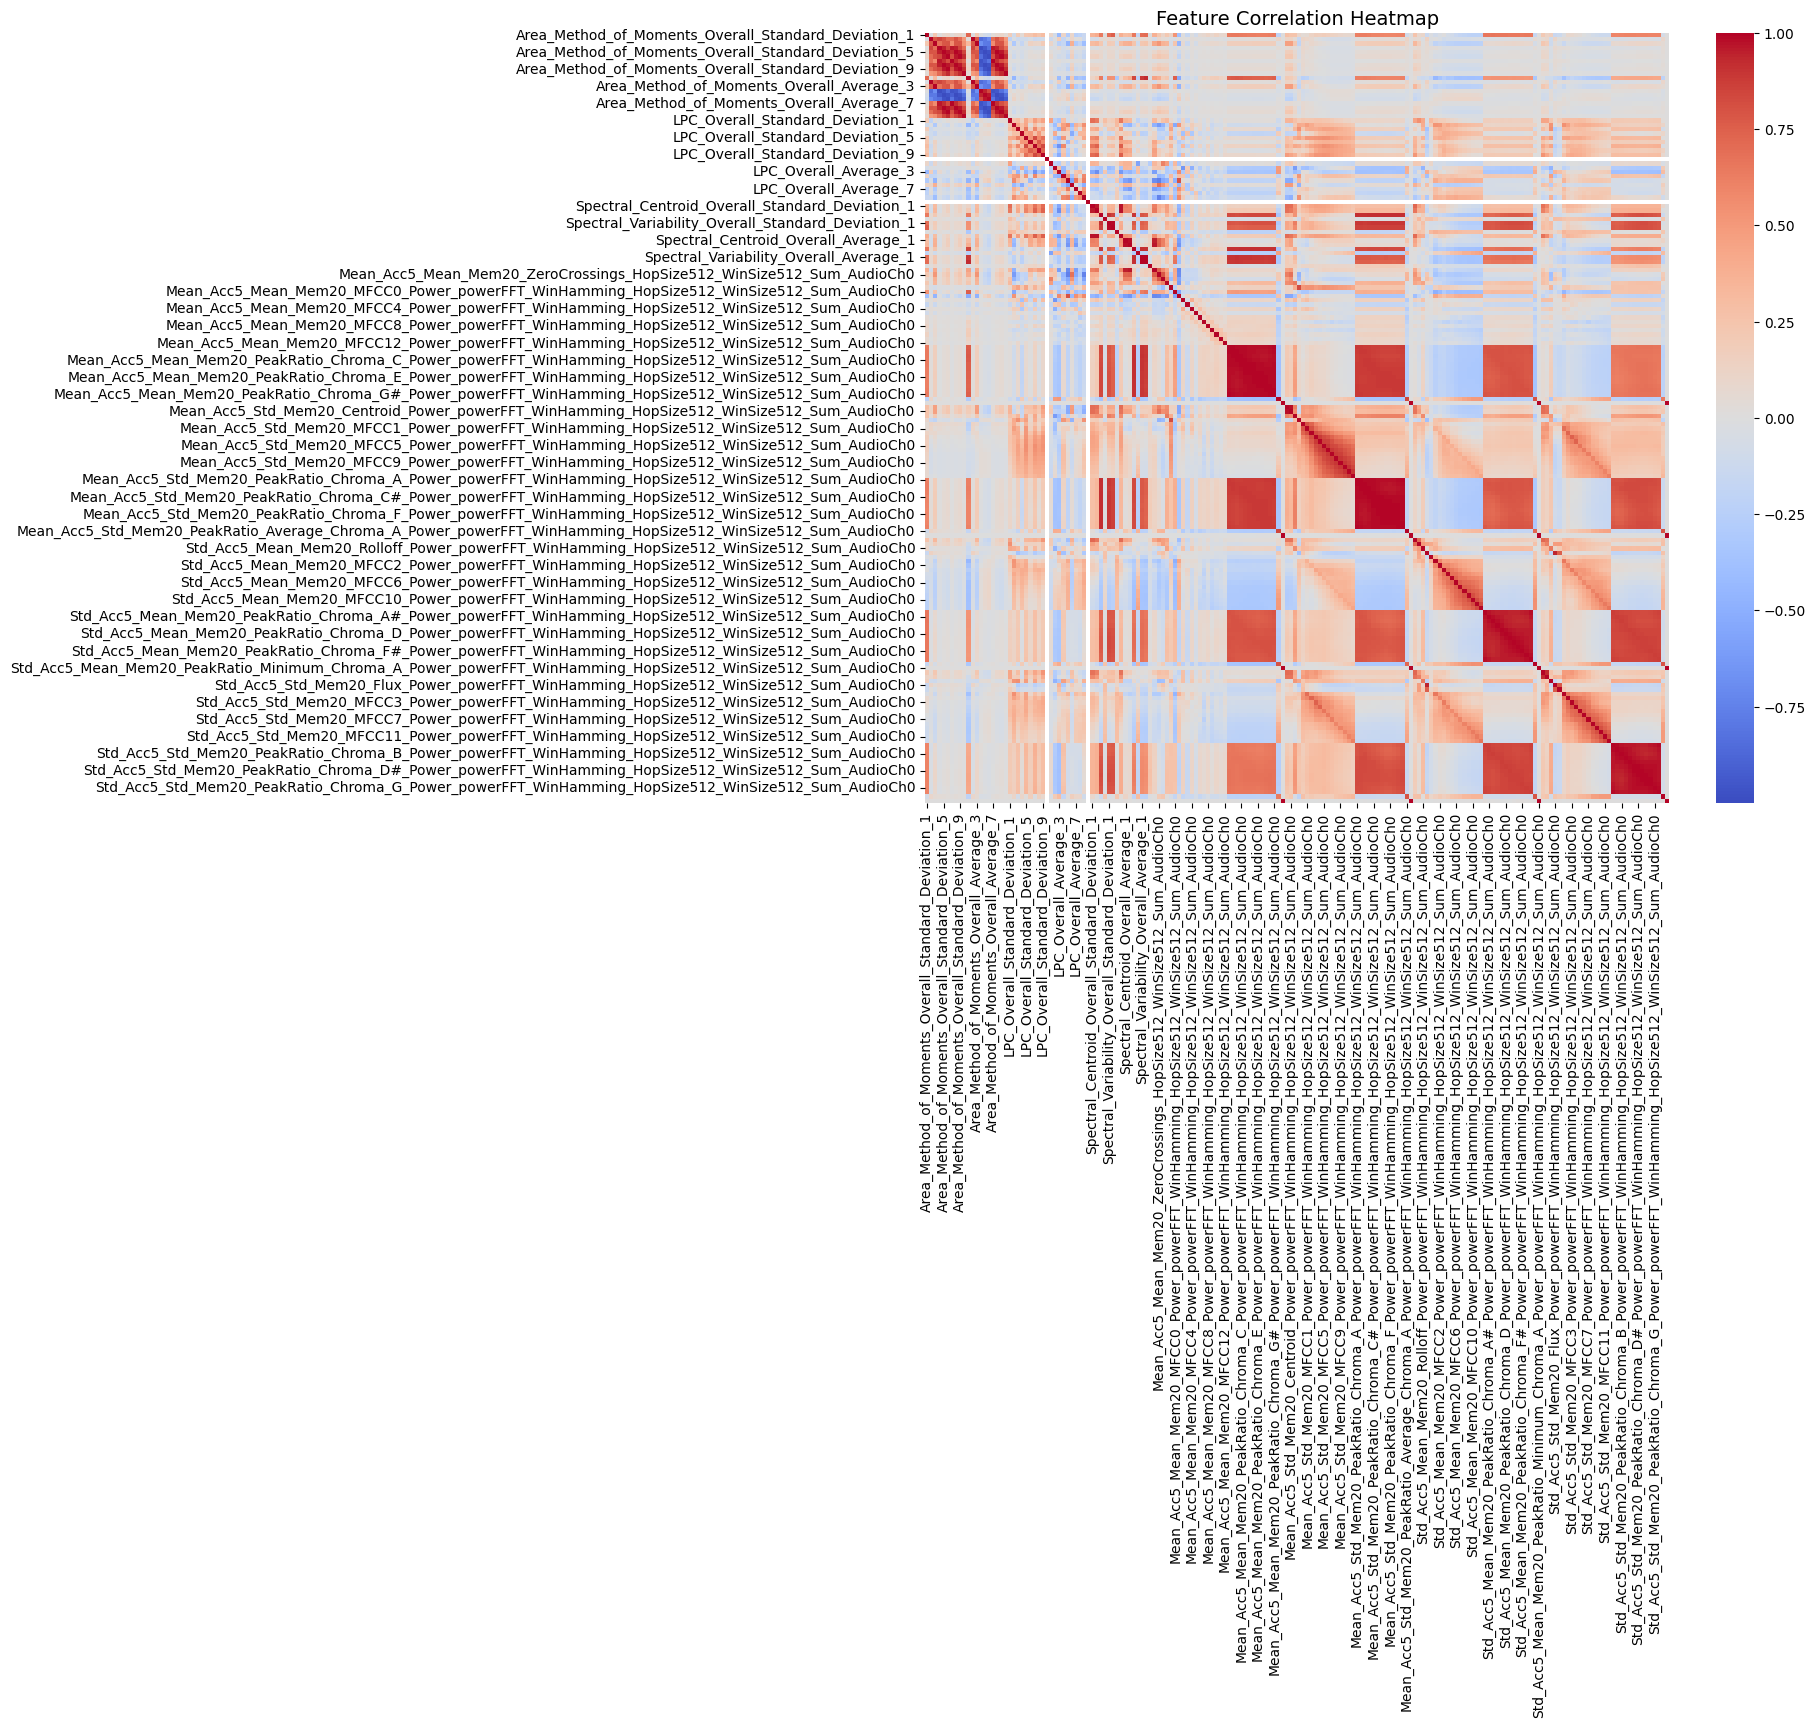

In [30]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric feature columns (skip track_id)
numeric_cols = [c for c, t in All_merges_clean.dtypes if t in ("int", "double", "float")]
print("Numeric feature count:", len(numeric_cols))

#clean_df = All_merges_clean.select(numeric_cols).na.drop()
clean_df = All_merges_clean.select(numeric_cols).fillna(0)

# clean_df = All_merges_clean.select(numeric_cols).fillna(0)

print("All_merges_clean count:", All_merges_clean.count())
print("clean_df count (after NA handling):", clean_df.count())

# Assemble features into vector
assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="features"
)
vec_df = assembler.transform(clean_df)
print("vec_df count:", vec_df.count())

# Compute correlation matrix (Pearson)
if vec_df.count() > 0:
    corr_matrix = Correlation.corr(vec_df, "features", "pearson").collect()[0][0]
    corr_array = corr_matrix.toArray()

    # Convert to Pandas DataFrame for plotting
    corr_df = pd.DataFrame(corr_array, index=numeric_cols, columns=numeric_cols)

    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_df, cmap="coolwarm", center=0)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()
else:
    print(" No rows left after cleaning — correlation cannot be computed.")


In [31]:
# Identify columns with |correlation| ≥ 0.9
import numpy as np
import seaborn as sns
upper_triangle = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() >= 0.9)]

print(f"\nColumns to drop (|corr| ≥ 0.9): {to_drop}")
print(f"Total columns before: {len(corr_df.columns)}")
print(f"Total columns after removing high correlations: {len(corr_df.columns) - len(to_drop)}")



Columns to drop (|corr| ≥ 0.9): ['Area_Method_of_Moments_Overall_Standard_Deviation_5', 'Area_Method_of_Moments_Overall_Standard_Deviation_6', 'Area_Method_of_Moments_Overall_Standard_Deviation_7', 'Area_Method_of_Moments_Overall_Standard_Deviation_8', 'Area_Method_of_Moments_Overall_Standard_Deviation_9', 'Area_Method_of_Moments_Overall_Standard_Deviation_10', 'Area_Method_of_Moments_Overall_Average_2', 'Area_Method_of_Moments_Overall_Average_3', 'Area_Method_of_Moments_Overall_Average_4', 'Area_Method_of_Moments_Overall_Average_5', 'Area_Method_of_Moments_Overall_Average_6', 'Area_Method_of_Moments_Overall_Average_7', 'Area_Method_of_Moments_Overall_Average_8', 'Area_Method_of_Moments_Overall_Average_9', 'Area_Method_of_Moments_Overall_Average_10', 'Spectral_Rolloff_Point_Overall_Standard_Deviation_1', 'Spectral_Variability_Overall_Standard_Deviation_1', 'Root_Mean_Square_Overall_Standard_Deviation_1', 'Zero_Crossings_Overall_Standard_Deviation_1', 'Spectral_Rolloff_Point_Overall_Av

Found 377 highly correlated pairs (|r| ≥ 0.9)


/tmp/ipykernel_81/2596567145.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


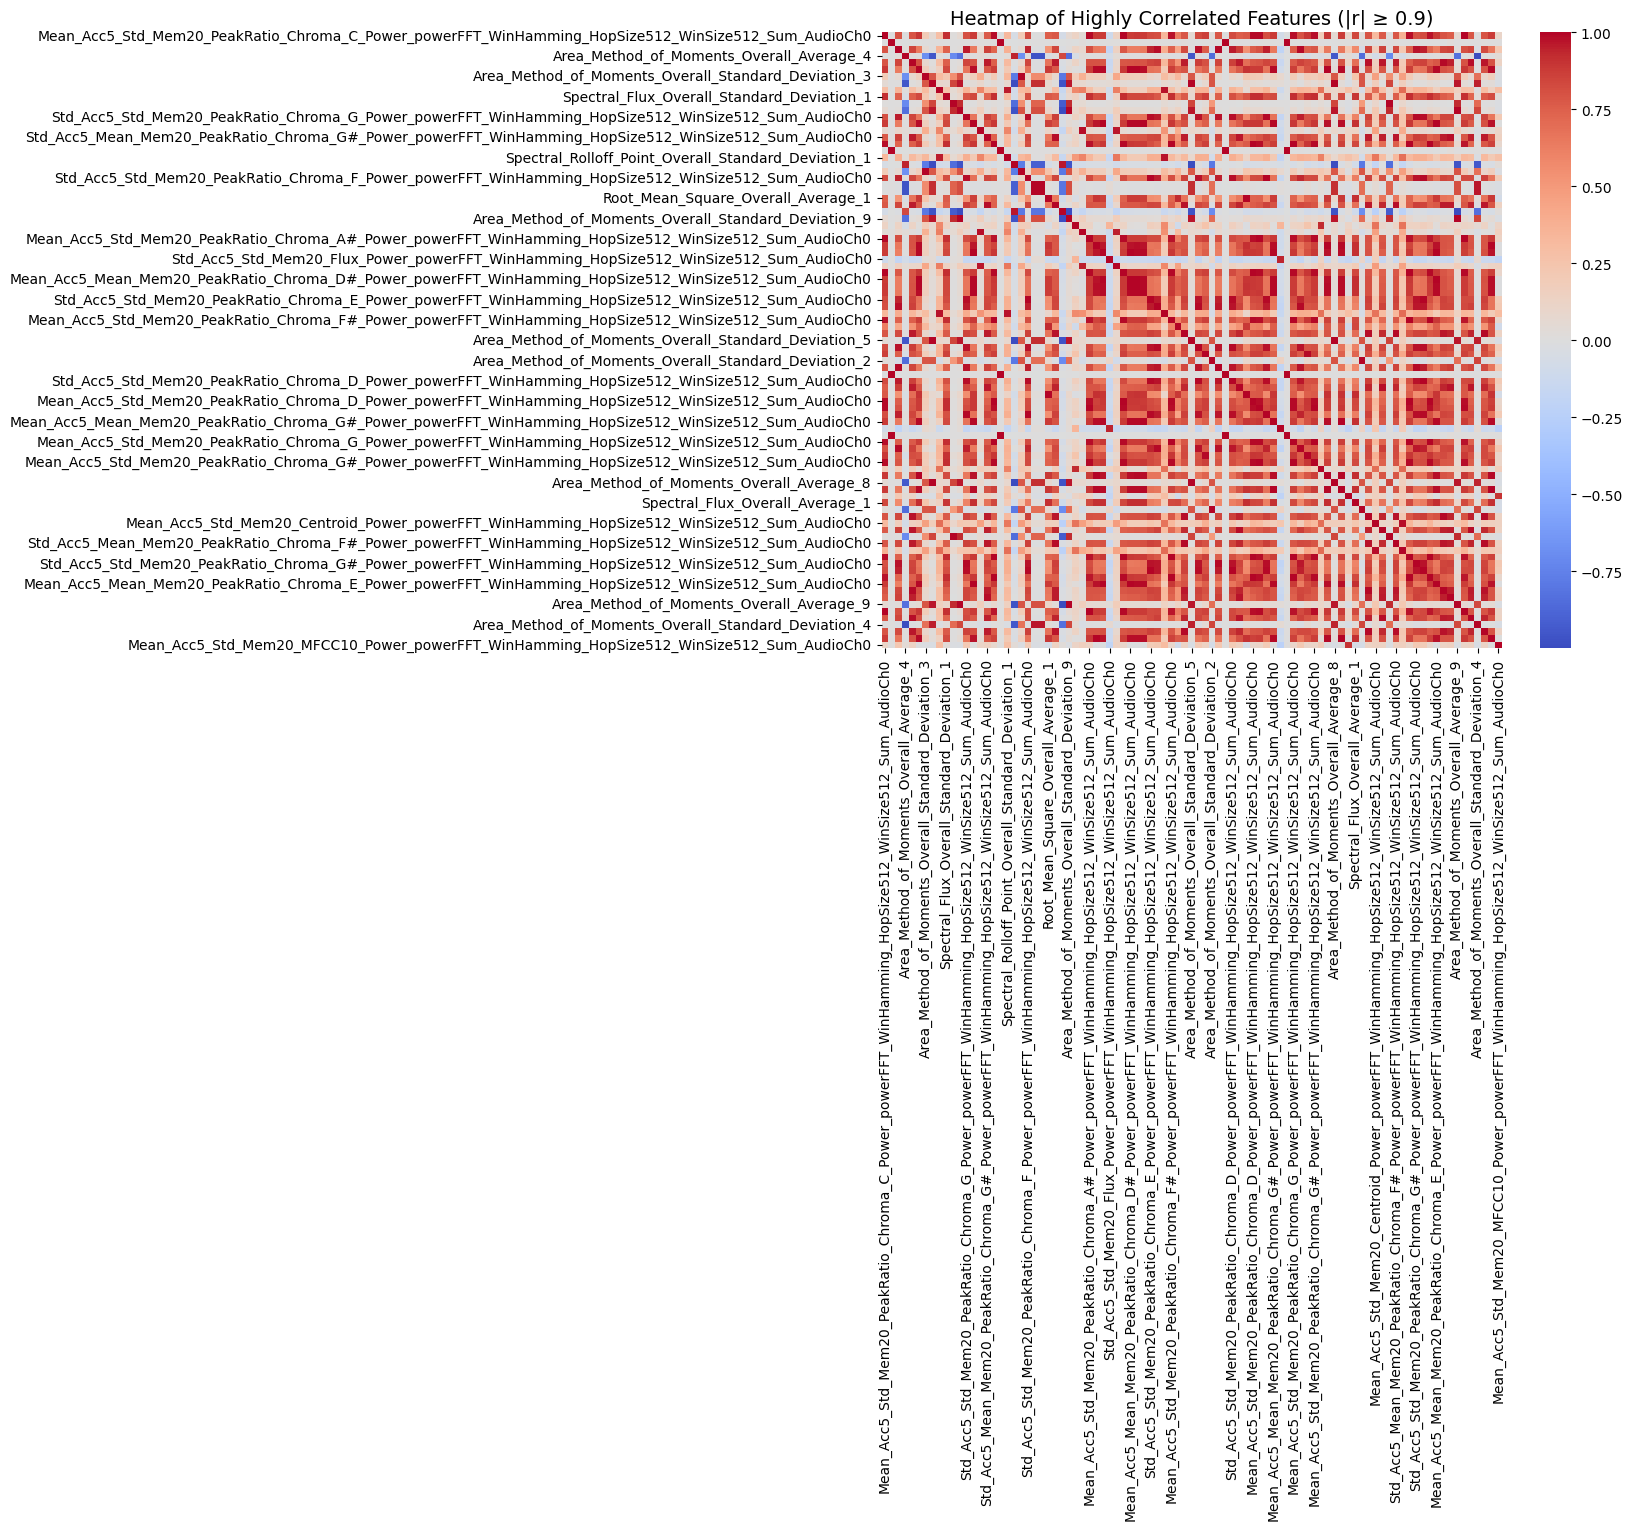

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set correlation threshold
threshold = 0.9

# Compute upper triangle of correlation matrix
upper_triangle = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(bool))

# Extract all pairs with |correlation| ≥ threshold
high_corr_pairs = (
    upper_triangle.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature_1', 'level_1': 'Feature_2', 0: 'Correlation'})
    .query('abs(Correlation) >= @threshold')
    .sort_values(by='Correlation', ascending=False)
)

print(f"Found {len(high_corr_pairs)} highly correlated pairs (|r| ≥ {threshold})")

# Get list of all unique features involved in high correlations
high_corr_features = list(set(high_corr_pairs['Feature_1']).union(set(high_corr_pairs['Feature_2'])))

# Filter the correlation matrix to only these features
high_corr_df = corr_df.loc[high_corr_features, high_corr_features]

# Plot heatmap for only the highly correlated variables
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr_df, cmap='coolwarm', center=0, annot=False)
plt.title(f"Heatmap of Highly Correlated Features (|r| ≥ {threshold})", fontsize=14)
plt.tight_layout()
plt.show()


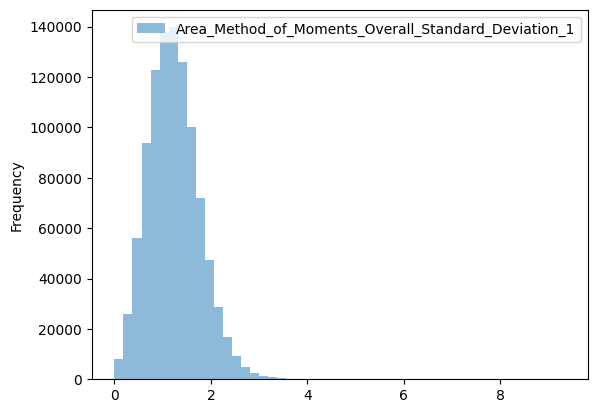

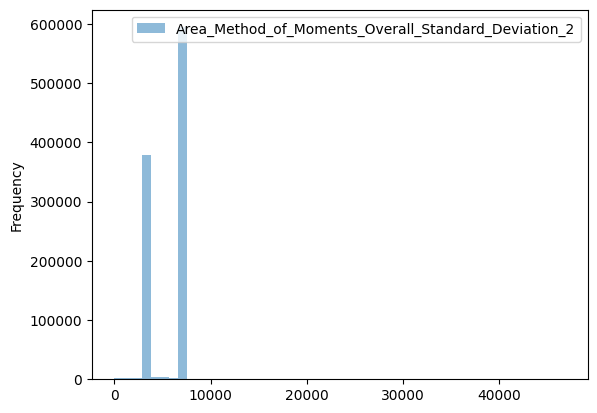

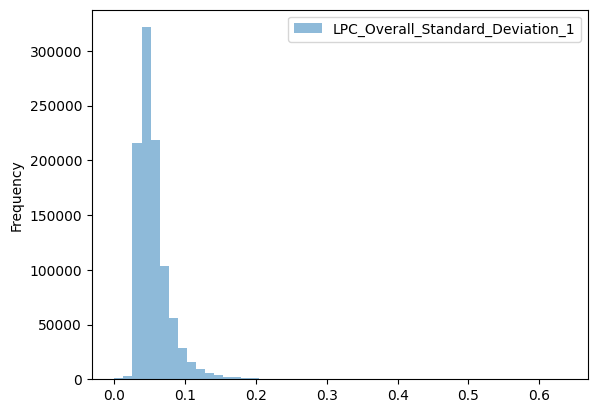

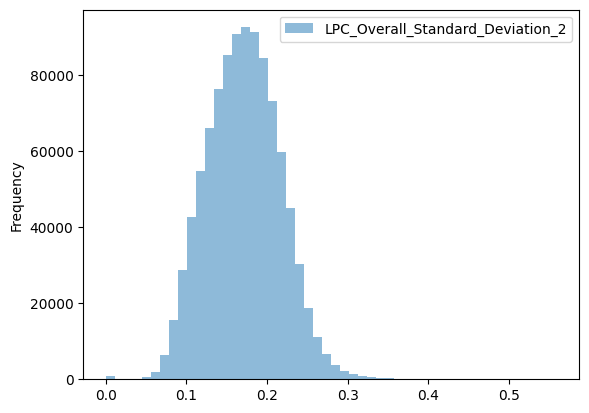

In [33]:
import matplotlib.pyplot as plt

cols = [
    "Area_Method_of_Moments_Overall_Standard_Deviation_1",
    "Area_Method_of_Moments_Overall_Standard_Deviation_2",
    "LPC_Overall_Standard_Deviation_1",
    "LPC_Overall_Standard_Deviation_2"
]

for c in cols:
    All_merges_clean.select(c).toPandas().plot(kind='hist', bins=50, alpha=0.5, label=c)
plt.legend()
plt.show()


In [79]:
# Check number of distinct values per column
for c in numeric_cols[:10]:  # check first 10 features
    print(c, clean_df.select(c).distinct().count())


Area_Method_of_Moments_Overall_Standard_Deviation_1 14109


Area_Method_of_Moments_Overall_Standard_Deviation_2 9583


Area_Method_of_Moments_Overall_Standard_Deviation_3 16354
Area_Method_of_Moments_Overall_Standard_Deviation_4 13496


Area_Method_of_Moments_Overall_Standard_Deviation_5 20664
Area_Method_of_Moments_Overall_Standard_Deviation_6 25930
Area_Method_of_Moments_Overall_Standard_Deviation_7 18218


Area_Method_of_Moments_Overall_Standard_Deviation_8 21171
Area_Method_of_Moments_Overall_Standard_Deviation_9 26107
Area_Method_of_Moments_Overall_Standard_Deviation_10 37129


After cleaning: 994594
Numeric columns: ['Area_Method_of_Moments_Overall_Standard_Deviation_1', 'Area_Method_of_Moments_Overall_Standard_Deviation_2', 'Area_Method_of_Moments_Overall_Standard_Deviation_3', 'Area_Method_of_Moments_Overall_Standard_Deviation_4', 'Area_Method_of_Moments_Overall_Standard_Deviation_5', 'Area_Method_of_Moments_Overall_Standard_Deviation_6', 'Area_Method_of_Moments_Overall_Standard_Deviation_7', 'Area_Method_of_Moments_Overall_Standard_Deviation_8', 'Area_Method_of_Moments_Overall_Standard_Deviation_9', 'Area_Method_of_Moments_Overall_Standard_Deviation_10', 'Area_Method_of_Moments_Overall_Average_1', 'Area_Method_of_Moments_Overall_Average_2', 'Area_Method_of_Moments_Overall_Average_3', 'Area_Method_of_Moments_Overall_Average_4', 'Area_Method_of_Moments_Overall_Average_5', 'Area_Method_of_Moments_Overall_Average_6', 'Area_Method_of_Moments_Overall_Average_7', 'Area_Method_of_Moments_Overall_Average_8', 'Area_Method_of_Moments_Overall_Average_9', 'Area_Method

25/10/24 15:03:03 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.
                                                                                

All_merges_clean count: 994623


clean_df count: 994594


vec_df count: 994594


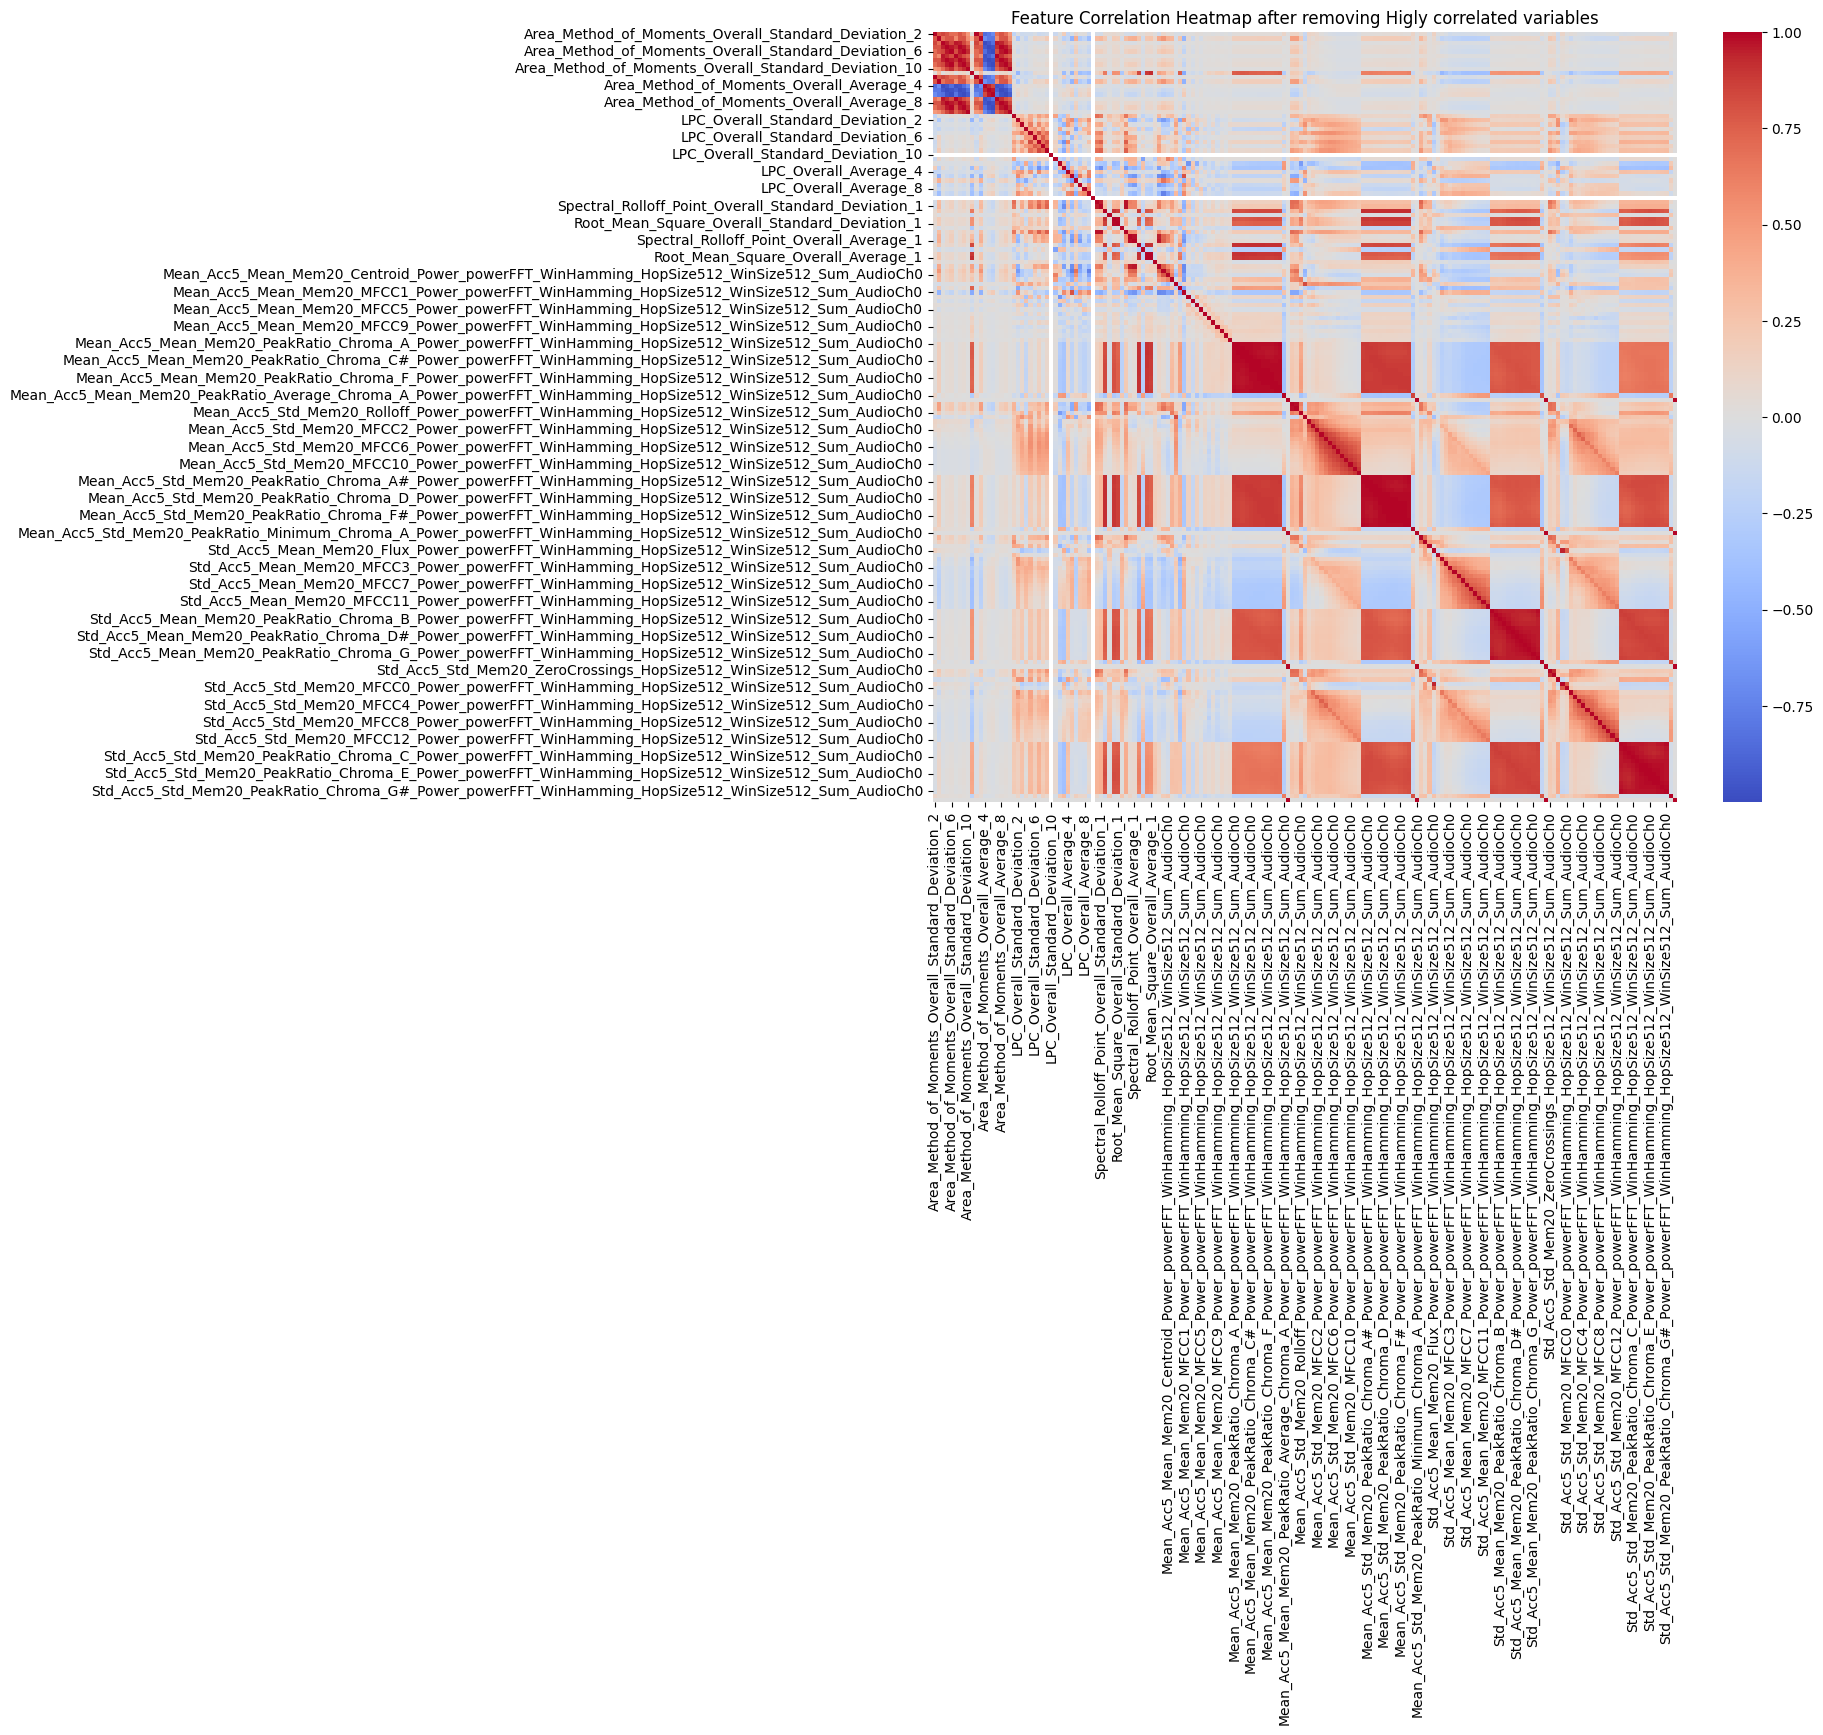

In [85]:
import seaborn as sns
# Drop rows with any nulls in feature columns
clean_df = All_merges_clean.drop("track_id")  # keep only features
clean_df = clean_df.na.drop()  # drop rows with missing values in features
print("After cleaning:", clean_df.count())


# clean_df = All_merges.fillna(0)
numeric_cols = [c for c, t in All_merges_clean.dtypes if t in ("int", "double", "float")]
print("Numeric columns:", numeric_cols)

assembler = VectorAssembler(
    inputCols=numeric_cols,  # skip track_id
    outputCol="features"
)

vec_df = assembler.transform(clean_df)

assembler = VectorAssembler(
    inputCols=clean_df.columns[1:],  # skip track_id
    outputCol="features"
)

vec_df = assembler.transform(clean_df)
corr_matrix = Correlation.corr(vec_df, "features", "pearson").collect()[0][0]
corr_array = corr_matrix.toArray()

print("All_merges_clean count:", All_merges_clean.count())
print("clean_df count:", clean_df.count())
print("vec_df count:", vec_df.count())

# Put into Pandas with column names
corr_df = pd.DataFrame(
    corr_array,
    index=clean_df.columns[1:],  # feature names
    columns=clean_df.columns[1:]
)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap after removing Higly correlated variables")
plt.show()

In [57]:
# Load the MSD All music Genre Dataset (MAGD)
!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/genre

Found 3 items
-rwxrwxrwx   1   11625230 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/genre/msd-MAGD-genreAssignment.tsv
-rwxrwxrwx   1    8820054 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/genre/msd-MASD-styleAssignment.tsv
-rwxrwxrwx   1   11140605 2024-09-13 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/genre/msd-topMAGD-genreAssignment.tsv


In [35]:

MASD_style = spark.read.csv(
    path=f'wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/genre/msd-MASD-styleAssignment.tsv',
    sep="\t",
    header=True,
    inferSchema = True
)

print(type(MASD_style))
#daily.printSchema()
print(MASD_style)
MASD_style.printSchema()
MASD_style.show(20, False)

<class 'pyspark.sql.dataframe.DataFrame'>
DataFrame[TRAAAAK128F9318786: string, Metal_Alternative: string]
root
 |-- TRAAAAK128F9318786: string (nullable = true)
 |-- Metal_Alternative: string (nullable = true)

+------------------+--------------------+
|TRAAAAK128F9318786|Metal_Alternative   |
+------------------+--------------------+
|TRAAAAV128F421A322|Punk                |
|TRAAAAW128F429D538|Hip_Hop_Rap         |
|TRAAACV128F423E09E|Rock_Neo_Psychedelia|
|TRAAAEF128F4273421|Pop_Indie           |
|TRAAAFP128F931B4E3|Hip_Hop_Rap         |
|TRAAAGR128F425B14B|Pop_Contemporary    |
|TRAAAHD128F42635A5|Rock_Hard           |
|TRAAAHJ128F931194C|Pop_Indie           |
|TRAAAHZ128E0799171|Hip_Hop_Rap         |
|TRAAAIR128F1480971|Pop_Contemporary    |
|TRAAAJG128F9308A25|Country_Traditional |
|TRAAAMO128F1481E7F|Gospel              |
|TRAAAMQ128F1460CD3|Hip_Hop_Rap         |
|TRAAANK128F428B515|Rock_Neo_Psychedelia|
|TRAAARJ128F9320760|Pop_Contemporary    |
|TRAAAVO128F93133D4|Rock_Neo_Psy

In [36]:
from pyspark.sql.types import StructType, StructField, StringType

schema = StructType([
    StructField("track_id", StringType(), True),
    StructField("genre", StringType(), True)
])

MAGD_data = spark.read.csv(
    path=f'wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/genre/msd-MAGD-genreAssignment.tsv',
    sep="\t",
    header=True,
     schema = schema
)

print(type(MAGD_data))
#daily.printSchema()
print(MAGD_data)
MAGD_data.printSchema()
MAGD_data.show(20, False)

<class 'pyspark.sql.dataframe.DataFrame'>
DataFrame[track_id: string, genre: string]
root
 |-- track_id: string (nullable = true)
 |-- genre: string (nullable = true)

+------------------+--------------+
|track_id          |genre         |
+------------------+--------------+
|TRAAAAV128F421A322|Pop_Rock      |
|TRAAAAW128F429D538|Rap           |
|TRAAABD128F429CF47|Pop_Rock      |
|TRAAACV128F423E09E|Pop_Rock      |
|TRAAADT12903CCC339|Easy_Listening|
|TRAAAED128E0783FAB|Vocal         |
|TRAAAEF128F4273421|Pop_Rock      |
|TRAAAEM128F93347B9|Electronic    |
|TRAAAFD128F92F423A|Pop_Rock      |
|TRAAAFP128F931B4E3|Rap           |
|TRAAAGR128F425B14B|Pop_Rock      |
|TRAAAGW12903CC1049|Blues         |
|TRAAAHD128F42635A5|Pop_Rock      |
|TRAAAHE12903C9669C|Pop_Rock      |
|TRAAAHJ128F931194C|Pop_Rock      |
|TRAAAHZ128E0799171|Rap           |
|TRAAAIR128F1480971|RnB           |
|TRAAAJG128F9308A25|Folk          |
|TRAAAMO128F1481E7F|Religious     |
|TRAAAMQ128F1460CD3|Rap           |
+---

In [37]:
genre_counts=MAGD_data.groupBy("genre").count().orderBy("count", ascending=False)
genre_counts.show(truncate=False)

+--------------+------+
|genre         |count |
+--------------+------+
|Pop_Rock      |238785|
|Electronic    |41075 |
|Rap           |20939 |
|Jazz          |17836 |
|Latin         |17590 |
|RnB           |14335 |
|International |14242 |
|Country       |11772 |
|Religious     |8814  |
|Reggae        |6946  |
|Blues         |6836  |
|Vocal         |6195  |
|Folk          |5865  |
|New Age       |4010  |
|Comedy_Spoken |2067  |
|Stage         |1614  |
|Easy_Listening|1545  |
|Avant_Garde   |1014  |
|Classical     |556   |
|Children      |477   |
+--------------+------+
only showing top 20 rows



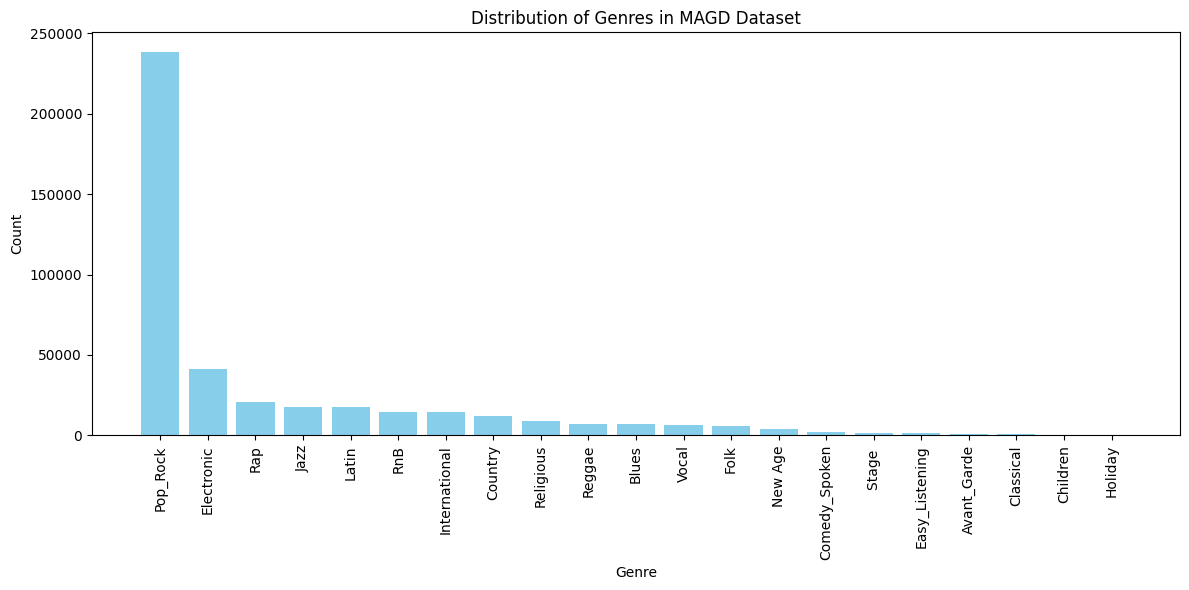

In [38]:
import matplotlib.pyplot as plt
# Convert to Pandas for plotting
genre_counts_pd = genre_counts.toPandas()

# Plot
plt.figure(figsize=(12,6))
plt.bar(genre_counts_pd["genre"], genre_counts_pd["count"], color="skyblue")
plt.xticks(rotation=90)
plt.title("Distribution of Genres in MAGD Dataset")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# b)

In [86]:
All_merges.sort('track_id').show(30, False)

[Stage 463:==========================================>              (6 + 2) / 8]

+------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----------------------------------------+--------------------------------+---------------

In [87]:
MAGD_data.sort('track_id').show(20, False)

+------------------+--------------+
|track_id          |genre         |
+------------------+--------------+
|TRAAAAV128F421A322|Pop_Rock      |
|TRAAAAW128F429D538|Rap           |
|TRAAABD128F429CF47|Pop_Rock      |
|TRAAACV128F423E09E|Pop_Rock      |
|TRAAADT12903CCC339|Easy_Listening|
|TRAAAED128E0783FAB|Vocal         |
|TRAAAEF128F4273421|Pop_Rock      |
|TRAAAEM128F93347B9|Electronic    |
|TRAAAFD128F92F423A|Pop_Rock      |
|TRAAAFP128F931B4E3|Rap           |
|TRAAAGR128F425B14B|Pop_Rock      |
|TRAAAGW12903CC1049|Blues         |
|TRAAAHD128F42635A5|Pop_Rock      |
|TRAAAHE12903C9669C|Pop_Rock      |
|TRAAAHJ128F931194C|Pop_Rock      |
|TRAAAHZ128E0799171|Rap           |
|TRAAAIR128F1480971|RnB           |
|TRAAAJG128F9308A25|Folk          |
|TRAAAMO128F1481E7F|Religious     |
|TRAAAMQ128F1460CD3|Rap           |
+------------------+--------------+
only showing top 20 rows



In [88]:
print("Audio features IDs:")
All_merges.select("track_id").show(5, False)

print("MAGD IDs:")
MAGD_data.select("track_id").show(5, False)


Audio features IDs:


+------------------+
|track_id          |
+------------------+
|TRBPYHN12903CC7C19|
|TRHFHLP128F14947A7|
|TRLQPGK128F93369E9|
|TRMMMKD128F425225D|
|TRBPYQU128F934F1B9|
+------------------+
only showing top 5 rows

MAGD IDs:
+------------------+
|track_id          |
+------------------+
|TRAAAAV128F421A322|
|TRAAAAW128F429D538|
|TRAAABD128F429CF47|
|TRAAACV128F423E09E|
|TRAAADT12903CCC339|
+------------------+
only showing top 5 rows



In [39]:
Audio_Genre = All_merges_clean.join(MAGD_data, "track_id", "inner")
Audio_Genre.show(20, False)

[Stage 292:==================================================>    (22 + 2) / 24]

+------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----------------------------------------+--------------------------------+---------------

In [90]:
print(Audio_Genre.columns)   # should list 'track_id', features..., 'genre'


['track_id', 'Area_Method_of_Moments_Overall_Standard_Deviation_1', 'Area_Method_of_Moments_Overall_Standard_Deviation_2', 'Area_Method_of_Moments_Overall_Standard_Deviation_3', 'Area_Method_of_Moments_Overall_Standard_Deviation_4', 'Area_Method_of_Moments_Overall_Standard_Deviation_5', 'Area_Method_of_Moments_Overall_Standard_Deviation_6', 'Area_Method_of_Moments_Overall_Standard_Deviation_7', 'Area_Method_of_Moments_Overall_Standard_Deviation_8', 'Area_Method_of_Moments_Overall_Standard_Deviation_9', 'Area_Method_of_Moments_Overall_Standard_Deviation_10', 'Area_Method_of_Moments_Overall_Average_1', 'Area_Method_of_Moments_Overall_Average_2', 'Area_Method_of_Moments_Overall_Average_3', 'Area_Method_of_Moments_Overall_Average_4', 'Area_Method_of_Moments_Overall_Average_5', 'Area_Method_of_Moments_Overall_Average_6', 'Area_Method_of_Moments_Overall_Average_7', 'Area_Method_of_Moments_Overall_Average_8', 'Area_Method_of_Moments_Overall_Average_9', 'Area_Method_of_Moments_Overall_Average_

In [91]:
Audio_Genre.select("track_id", "genre").show(10, truncate=False)



[Stage 502:=======>                                                 (1 + 7) / 8]

+------------------+----------+
|track_id          |genre     |
+------------------+----------+
|TRAAABD128F429CF47|Pop_Rock  |
|TRAAAEM128F93347B9|Electronic|
|TRAAAFD128F92F423A|Pop_Rock  |
|TRAAAHZ128E0799171|Rap       |
|TRAABXA128F9326351|Pop_Rock  |
|TRAACOW128F933E35F|Pop_Rock  |
|TRAACRY12903CAF2C2|Pop_Rock  |
|TRAACZK128F4243829|Latin     |
|TRAADKW128E079503A|Pop_Rock  |
|TRAADLX128F1469250|Folk      |
+------------------+----------+
only showing top 10 rows



In [40]:
from pyspark.sql.functions import regexp_replace, trim, upper

# Remove apostrophes and normalize
All_merges_clean = All_merges.withColumn(
    "track_id", regexp_replace(trim(All_merges["track_id"]), "'", "")
)

MAGD_clean = MAGD_data.withColumn(
    "track_id", trim(MAGD_data["track_id"])
)

# Verify lengths are consistent
All_merges_clean.selectExpr("length(track_id)").distinct().show()
MAGD_clean.selectExpr("length(track_id)").distinct().show()

# Try join again
Audio_Genre = All_merges_clean.join(MAGD_clean, "track_id", "inner")

print("Final merged count:", Audio_Genre.count())
Audio_Genre.show(10, truncate=False)


+----------------+
|length(track_id)|
+----------------+
|              18|
|            NULL|
+----------------+

+----------------+
|length(track_id)|
+----------------+
|              18|
+----------------+



Final merged count: 420603


[Stage 327:====================================================>  (23 + 1) / 24]

+------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----------------------------------------+--------------------------------+---------------

# Q)2)

In [41]:
Audio_Genre_Elctronic = Audio_Genre.withColumn(
    "isElctronic",
    F.when(F.col("genre") == "Electronic", 1).otherwise(0)
)

Audio_Genre_Elctronic.select("track_id", "genre", "isElctronic").show(10, False)
print("Electronic Count:",Audio_Genre_Elctronic.filter(F.col("isElctronic") == 1).count())
print("Non-Electronic Count:",Audio_Genre_Elctronic.filter(F.col("isElctronic") == 0).count())
print("Total Count:",Audio_Genre_Elctronic.count())
#Audio_Genre_Elctronic.when(F.col(isElectronic==0)).count()
#Audio_Genre_Elctronic.count()

+------------------+----------+-----------+
|track_id          |genre     |isElctronic|
+------------------+----------+-----------+
|TRAAABD128F429CF47|Pop_Rock  |0          |
|TRAAAEM128F93347B9|Electronic|1          |
|TRAAAMO128F1481E7F|Religious |0          |
|TRAABPQ128F428F0B0|Latin     |0          |
|TRAABXH128F42955D6|Pop_Rock  |0          |
|TRAACQE12903CC706C|Pop_Rock  |0          |
|TRAACRY12903CAF2C2|Pop_Rock  |0          |
|TRAADYB128F92D7E73|Jazz      |0          |
|TRAAEDF128F930CC0F|Jazz      |0          |
|TRAAEHK128F92C9C79|Blues     |0          |
+------------------+----------+-----------+
only showing top 10 rows



Electronic Count: 40662


Non-Electronic Count: 379941


[Stage 376:==========================================>              (6 + 2) / 8]

Total Count: 420603


In [43]:
training, test = Audio_Genre_Elctronic.randomSplit([0.8, 0.2],seed=10)
#training.cache()
#test.cache()
'''trn_cls_bal = training.groupBy('isElctronic').count().collect()
tst_cls_bal = test.groupBy('isElctronic').count().collect()
print("Training Class Blanac3e",trn_cls_bal)
print("Training Class Blanac3e",tst_cls_bal)'''
show_class_balance(Audio_Genre_Elctronic, "Audio_Genre_Elctronic",labelCol="isElctronic")
show_class_balance(training, "training",labelCol="isElctronic")
show_class_balance(test, "test",labelCol="isElctronic")

Class balance [Audio_Genre_Elctronic]

total:   420603
counts:
   isElctronic   count     ratio
0            0  379941  0.903325
1            1   40662  0.096675



Class balance [training]

total:   336331
counts:
   isElctronic   count     ratio
0            0  303799  0.903274
1            1   32532  0.096726



[Stage 506:====================================================>  (23 + 1) / 24]

Class balance [test]

total:   84272
counts:
   isElctronic  count     ratio
0            0  76142  0.903527
1            1   8130  0.096473



In [44]:
# Now oversample the minority class:
mjrty_cls_data = training.filter(F.col("isElctronic")==0)
mnrty_cls_data = training.filter(F.col("isElctronic")==1)

ovrsmpld_mnrty_data = mnrty_cls_data.sample(withReplacement=True, fraction = mjrty_cls_data.count()/mnrty_cls_data.count(),seed=10)
balanced_train_data = mjrty_cls_data.union(ovrsmpld_mnrty_data)
show_class_balance(balanced_train_data, "Balace class",labelCol="isElctronic")
balanced_train_data.show(10, truncate=False)

Class balance [Balace class]

total:   608000
counts:
   isElctronic   count     ratio
0            0  303799  0.499669
1            1  304201  0.500331



[Stage 624:====================================================>  (23 + 1) / 24]

+------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+---------------------------------------------------+----------------------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+----------------------------------------+-----------------------------------------+--------------------------------+---------------

In [45]:
#import the required pyspark libraries:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Choose feature columns (example — use your dataset’s actual columns)
feature_cols = [col for col in balanced_train_data.columns if col not in ["genre", "isElctronic", "track_id"]]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
assembled_train_data = assembler.transform(balanced_train_data)
assembled_test_data = assembler.transform(test)
#assembled_train_data.printSchema()
# Scale features for better performance (especially for Logistic Regression)
#scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=False, withStd=True)
scaler_model = scaler.fit(assembled_train_data)
scaled_train_data = scaler_model.transform(assembled_train_data)
scaled_test_data = scaler_model.transform(assembled_test_data)

# Define evaluator (to measure accuracy)
evaluator = MulticlassClassificationEvaluator(labelCol="isElctronic", predictionCol="prediction", metricName="accuracy")

# Logistic Regression (requires scaled features)

lr = LogisticRegression(labelCol="isElctronic", featuresCol="scaledFeatures")
lr_model = lr.fit(scaled_train_data)
lr_predictions = lr_model.transform(scaled_test_data)
lr_accuracy = evaluator.evaluate(lr_predictions)
print("Logistic Regression Model Accuracy:", lr_accuracy)


# Random Forest Classifier (tree-based, scaling not needed)

rf = RandomForestClassifier(labelCol="isElctronic", featuresCol="features", numTrees=100)
rf_model = rf.fit(assembled_train_data)
rf_predictions = rf_model.transform(assembled_test_data)
rf_accuracy = evaluator.evaluate(rf_predictions)
print("Random Forest Model Accuracy:", rf_accuracy)


# Gradient-Boosted Tree Classifier (tree-based, scaling not needed)
gbt = GBTClassifier(labelCol="isElctronic", featuresCol="features", maxIter=50)
gbt_model = gbt.fit(assembled_train_data)
gbt_predictions = gbt_model.transform(assembled_test_data)
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print("Gradient-Boosted Tree Model Accuracy:", gbt_accuracy)

25/10/24 12:43:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
                                                                                

Logistic Regression Model Accuracy: 0.8381293683473555


Random Forest Model Accuracy: 0.8073002575025809


[Stage 3798:========================================>             (18 + 6) / 24]

Gradient-Boosted Tree Model Accuracy: 0.8314841404516382


In [46]:
# 2) (e)

lr_accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
lr_precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
lr_recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})
lr_f1 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "f1"})

print("Logistic Regression Metrics:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1 Score: {lr_f1:.4f}")

rf_accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
rf_precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedPrecision"})
rf_recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedRecall"})
rf_f1 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})

print("\n RF Metrics:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")

gbt_accuracy = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "accuracy"})
gbt_precision = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "weightedPrecision"})
gbt_recall = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "weightedRecall"})
gbt_f1 = evaluator.evaluate(gbt_predictions, {evaluator.metricName: "f1"})

print("\nGradient Boosting Tree Metrics:")
print(f"Accuracy: {gbt_accuracy:.4f}")
print(f"Precision: {gbt_precision:.4f}")
print(f"Recall: {gbt_recall:.4f}")
print(f"F1 Score: {gbt_f1:.4f}")

Logistic Regression Metrics:
Accuracy: 0.8381
Precision: 0.9123
Recall: 0.8381
F1 Score: 0.8633



 RF Metrics:
Accuracy: 0.8073
Precision: 0.8997
Recall: 0.8073
F1 Score: 0.8395


[Stage 4014:=================================================>    (22 + 2) / 24]


Gradient Boosting Tree Metrics:
Accuracy: 0.8315
Precision: 0.9105
Recall: 0.8315
F1 Score: 0.8583


# Q3)

In [99]:
MAGD_data.show(10, truncate=False)

+------------------+--------------+
|track_id          |genre         |
+------------------+--------------+
|TRAAAAV128F421A322|Pop_Rock      |
|TRAAAAW128F429D538|Rap           |
|TRAAABD128F429CF47|Pop_Rock      |
|TRAAACV128F423E09E|Pop_Rock      |
|TRAAADT12903CCC339|Easy_Listening|
|TRAAAED128E0783FAB|Vocal         |
|TRAAAEF128F4273421|Pop_Rock      |
|TRAAAEM128F93347B9|Electronic    |
|TRAAAFD128F92F423A|Pop_Rock      |
|TRAAAFP128F931B4E3|Rap           |
+------------------+--------------+
only showing top 10 rows



In [47]:
# b)
from pyspark.ml.feature import StringIndexer

# Create and fit the indexer
indexer = StringIndexer(inputCol="genre", outputCol="genre_index")

# Transform the data to add a new numeric column
MAGD_indexed = indexer.fit(MAGD_data).transform(MAGD_data)

# Show the result
MAGD_indexed.select("track_id", "genre", "genre_index").show(10, truncate=False)


+------------------+--------------+-----------+
|track_id          |genre         |genre_index|
+------------------+--------------+-----------+
|TRAAAAV128F421A322|Pop_Rock      |0.0        |
|TRAAAAW128F429D538|Rap           |2.0        |
|TRAAABD128F429CF47|Pop_Rock      |0.0        |
|TRAAACV128F423E09E|Pop_Rock      |0.0        |
|TRAAADT12903CCC339|Easy_Listening|16.0       |
|TRAAAED128E0783FAB|Vocal         |11.0       |
|TRAAAEF128F4273421|Pop_Rock      |0.0        |
|TRAAAEM128F93347B9|Electronic    |1.0        |
|TRAAAFD128F92F423A|Pop_Rock      |0.0        |
|TRAAAFP128F931B4E3|Rap           |2.0        |
+------------------+--------------+-----------+
only showing top 10 rows



In [101]:
MAGD_indexed.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- genre_index: double (nullable = false)



In [48]:
MAGD_indexed = MAGD_indexed.withColumn("genre_index", col("genre_index").cast("integer"))
MAGD_indexed.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- genre_index: integer (nullable = true)



In [49]:
MAGD_indexed.select("track_id", "genre", "genre_index").show(10, truncate=False)

+------------------+--------------+-----------+
|track_id          |genre         |genre_index|
+------------------+--------------+-----------+
|TRAAAAV128F421A322|Pop_Rock      |0          |
|TRAAAAW128F429D538|Rap           |2          |
|TRAAABD128F429CF47|Pop_Rock      |0          |
|TRAAACV128F423E09E|Pop_Rock      |0          |
|TRAAADT12903CCC339|Easy_Listening|16         |
|TRAAAED128E0783FAB|Vocal         |11         |
|TRAAAEF128F4273421|Pop_Rock      |0          |
|TRAAAEM128F93347B9|Electronic    |1          |
|TRAAAFD128F92F423A|Pop_Rock      |0          |
|TRAAAFP128F931B4E3|Rap           |2          |
+------------------+--------------+-----------+
only showing top 10 rows



In [50]:
# see the metrics of unbalanced class
# The below code is just to see the metrics for the imbalanced class
feature_columns = [col for col in MAGD_indexed.columns if col not in ['track_id', 'genre']]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

lr = LogisticRegression(labelCol="genre_index", featuresCol="features", maxIter=10)

pipeline = Pipeline(stages=[assembler, lr])

max_genre_count = MAGD_indexed.groupBy("genre_index").count().agg({"count": "max"}).collect()[0][0]
oversampled_data_list = []
for genre, count in MAGD_indexed.groupBy("genre_index").count().collect():
    if count < max_genre_count:
        oversampled_genre_data = MAGD_indexed.filter(col("genre_index") == genre).sample(True, max_genre_count / count, seed=123)
        oversampled_data_list.append(oversampled_genre_data)

oversampled_data = oversampled_data_list[0]
for i in range(1, len(oversampled_data_list)):
    oversampled_data = oversampled_data.unionAll(oversampled_data_list[i])

train_data, test_data = oversampled_data.randomSplit([0.8, 0.2], seed=1234)

lr_model = pipeline.fit(train_data)

predictions = lr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="genre_index", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


[Stage 4060:================================================>     (54 + 6) / 60]

Accuracy: 0.6998776109831568
Precision: 0.5831311846648924
Recall: 0.6998776109831567
F1 Score: 0.616490184439329


In [51]:
#Check if the class is balanced or not
class_distribution = MAGD_indexed.groupBy("genre_index").count().orderBy("genre_index").collect()

print("Class Distribution:")
for row in class_distribution:
    genre_index = row["genre_index"]
    count = row["count"]
    print("Genre:", genre_index, "Count:", count)


Class Distribution:
Genre: 0 Count: 238785
Genre: 1 Count: 41075
Genre: 2 Count: 20939
Genre: 3 Count: 17836
Genre: 4 Count: 17590
Genre: 5 Count: 14335
Genre: 6 Count: 14242
Genre: 7 Count: 11772
Genre: 8 Count: 8814
Genre: 9 Count: 6946
Genre: 10 Count: 6836
Genre: 11 Count: 6195
Genre: 12 Count: 5865
Genre: 13 Count: 4010
Genre: 14 Count: 2067
Genre: 15 Count: 1614
Genre: 16 Count: 1545
Genre: 17 Count: 1014
Genre: 18 Count: 556
Genre: 19 Count: 477
Genre: 20 Count: 200


In [52]:
#(c) Split your dataset into training and test sets
feature_columns = [col for col in MAGD_indexed.columns if col not in ['track_id', 'genre']]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

lr = LogisticRegression(labelCol="genre_index", featuresCol="features", maxIter=10)

pipeline = Pipeline(stages=[assembler, lr])

max_genre_count = MAGD_indexed.groupBy("genre_index").count().agg({"count": "max"}).collect()[0][0]
oversampled_data_list = []
for row in MAGD_indexed.groupBy("genre_index").count().collect():
    genre, count = row['genre_index'], row['count']
    oversampled_genre_data = MAGD_indexed.filter(col("genre_index") == genre)
    if count < max_genre_count:
        oversampled_genre_data = oversampled_genre_data.sample(True, max_genre_count / count, seed=54)
    oversampled_data_list.append(oversampled_genre_data)

oversampled_data = oversampled_data_list[0]
for i in range(1, len(oversampled_data_list)):
    oversampled_data = oversampled_data.union(oversampled_data_list[i])

train_data, test_data = oversampled_data.randomSplit([0.8, 0.2], seed=34)

lr_model = pipeline.fit(train_data)

predictions = lr_model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="genre_index", predictionCol="prediction")

def evaluate_model_per_genre(predictions, num_classes):
    genre_metrics = {}
    
    for genre_index in range(num_classes):
        genre_predictions = predictions.filter(predictions["genre_index"] == genre_index)
        genre_accuracy = evaluator.evaluate(genre_predictions, {evaluator.metricName: "accuracy"})
        genre_precision = evaluator.evaluate(genre_predictions, {evaluator.metricName: "weightedPrecision"})
        genre_recall = evaluator.evaluate(genre_predictions, {evaluator.metricName: "weightedRecall"})
        genre_f1 = evaluator.evaluate(genre_predictions, {evaluator.metricName: "f1"})
        
        genre_metrics[genre_index] = {
            "Accuracy": genre_accuracy,
            "Precision": genre_precision,
            "Recall": genre_recall,
            "F1 Score": genre_f1
        }
    
    return genre_metrics

num_classes = MAGD_indexed.select("genre_index").distinct().count()
lr_genre_metrics = evaluate_model_per_genre(predictions, num_classes)

for genre_index, metrics in lr_genre_metrics.items():
    print(f"Genre {genre_index}:")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  Precision: {metrics['Precision']:.4f}")
    print(f"  Recall: {metrics['Recall']:.4f}")
    print(f"  F1 Score: {metrics['F1 Score']:.4f}")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print("Overall Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Genre 0:
  Accuracy: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Genre 1:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 2:
  Accuracy: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Genre 3:
  Accuracy: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Genre 4:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 5:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 6:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 7:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 8:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 9:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 10:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
Genre 11:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Scor

[Stage 4283:==================================================>   (59 + 4) / 63]

Overall Metrics:
Accuracy: 0.7143
Precision: 0.6031
Recall: 0.7143
F1 Score: 0.6349


In [53]:
# Checking to see if the class is balanced
class_distribution = oversampled_data.groupBy("genre_index").count().orderBy("genre_index").collect()

print("Class Distribution:")
for row in class_distribution:
    genre_index = row["genre_index"]
    count = row["count"]
    print("Genre:", genre_index, "Count:", count)


[Stage 4285:=====================================================>(62 + 1) / 63]

Class Distribution:
Genre: 0 Count: 238785
Genre: 1 Count: 238761
Genre: 2 Count: 238361
Genre: 3 Count: 238742
Genre: 4 Count: 238702
Genre: 5 Count: 238579
Genre: 6 Count: 238568
Genre: 7 Count: 238510
Genre: 8 Count: 238521
Genre: 9 Count: 238572
Genre: 10 Count: 238551
Genre: 11 Count: 238428
Genre: 12 Count: 238919
Genre: 13 Count: 239609
Genre: 14 Count: 238505
Genre: 15 Count: 237893
Genre: 16 Count: 238606
Genre: 17 Count: 238222
Genre: 18 Count: 238005
Genre: 19 Count: 238392
Genre: 20 Count: 238134


# Q4

In [54]:
print(type(balanced_train_data))
print(type(test))


<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
# Import the required pyspark libraries
'''from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col

# Choose feature columns (use your dataset’s actual columns)
feature_cols = [col for col in balanced_train_data.columns if col not in ["genre", "isElctronic", "track_id"]]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
assembled_train_data = assembler.transform(balanced_train_data)
assembled_test_data = assembler.transform(test)

# Scale features (important for Logistic Regression)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=False, withStd=True)
scaler_model = scaler.fit(assembled_train_data)
scaled_train_data = scaler_model.transform(assembled_train_data)
scaled_test_data = scaler_model.transform(assembled_test_data)

# Define evaluator (for accuracy)
evaluator = MulticlassClassificationEvaluator(labelCol="isElctronic", predictionCol="prediction", metricName="accuracy")

# -----------------------------
# STEP 4: Logistic Regression with Grid Search
# -----------------------------
lr = LogisticRegression(labelCol="isElctronic", featuresCol="scaledFeatures")

# Define hyperparameter grid
lr_param_grid = (ParamGridBuilder()
    .addGrid(lr.maxIter, [10, 50, 100])
    .addGrid(lr.regParam, [0.0, 0.1, 0.5])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
    .build())

# Cross-validator
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_param_grid,
                       evaluator=evaluator, numFolds=3, parallelism=2)

lr_model = lr_cv.fit(scaled_train_data)
lr_predictions = lr_model.transform(scaled_test_data)
lr_accuracy = evaluator.evaluate(lr_predictions)
print("Best Logistic Regression Accuracy:", lr_accuracy)
print("Best LR Params:", lr_model.bestModel.extractParamMap())
'''
'''
# -----------------------------
# STEP 5: Random Forest with Grid Search
# -----------------------------
rf = RandomForestClassifier(labelCol="isElctronic", featuresCol="features")

rf_param_grid = (ParamGridBuilder()
    .addGrid(rf.numTrees, [50, 100, 150])
    .addGrid(rf.maxDepth, [5, 10, 15])
    .addGrid(rf.featureSubsetStrategy, ["auto", "sqrt"])
    .build())

rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_param_grid,
                       evaluator=evaluator, numFolds=3, parallelism=2)

rf_model = rf_cv.fit(assembled_train_data)
rf_predictions = rf_model.transform(assembled_test_data)
rf_accuracy = evaluator.evaluate(rf_predictions)
print("Best Random Forest Accuracy:", rf_accuracy)
print("Best RF Params:", rf_model.bestModel.extractParamMap())

# -----------------------------
# STEP 6: Gradient Boosted Tree with Grid Search
# -----------------------------
gbt = GBTClassifier(labelCol="isElctronic", featuresCol="features")

gbt_param_grid = (ParamGridBuilder()
    .addGrid(gbt.maxIter, [20, 50, 100])
    .addGrid(gbt.maxDepth, [3, 5, 8])
    .addGrid(gbt.stepSize, [0.05, 0.1, 0.2])
    .build())

gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_param_grid,
                        evaluator=evaluator, numFolds=3, parallelism=2)

gbt_model = gbt_cv.fit(assembled_train_data)
gbt_predictions = gbt_model.transform(assembled_test_data)
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print("Best GBT Accuracy:", gbt_accuracy)
print("Best GBT Params:", gbt_model.bestModel.extractParamMap())
'''

## Song Recommendations

# Q1)

In [55]:
!hdfs dfs -ls wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/tasteprofile

Found 2 items
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/tasteprofile/mismatches
drwxrwxrwx   -          0 1970-01-01 12:00 wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/tasteprofile/triplets.tsv


In [56]:
!hdfs dfs -du -s -h wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/tasteprofile/triplets.tsv


488.4 M  488.4 M  wasbs://campus-data@madsstorage002.blob.core.windows.net/msd/tasteprofile/triplets.tsv


In [57]:
spark

In [111]:
print(type(mismatches_data))
#daily.printSchema()
print(mismatches_data)
mismatches_data.show(20, False)

<class 'pyspark.sql.dataframe.DataFrame'>
DataFrame[ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10> Digital Underground  -  The Way We Swing  !=  Linkwood  -  Whats up with the Underground: string]
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ERROR: <SOUMNSI12AB0182807 TRMMGKQ128F9325E10> Digital Underground  -  The Way We Swing  !=  Linkwood  -  Whats up with the Underground                                   |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ERROR: <SOCMRBE12AB018C546 TRMMREB12903CEB1B1> Jimmy Reed  -  The Sun Is Shining (Digitally Remastered)  !=  Slim Harpo  -  I Got Love If You Want It                     |
|ERROR: <SOLPHZY12AC468ABA8 TRMMBOC12903CEB46E> Africa HiTech  -  Footstep  !=  Marcus Worgull  -  Drumstern (B

In [58]:
schema = StructType([
    StructField('user_id', StringType(), True),
    StructField('song_id', StringType(), True),
    StructField('play_count', IntegerType(), True)
])

triplets_data = spark.read.csv(
    path=f'wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/msd/tasteprofile/triplets.tsv',
      sep="\t",
    header=False,inferSchema = True, schema=schema
)


print(type(triplets_data))
#daily.printSchema()
print(triplets_data)
triplets_data.show(20, False)

<class 'pyspark.sql.dataframe.DataFrame'>
DataFrame[user_id: string, song_id: string, play_count: int]
+----------------------------------------+------------------+----------+
|user_id                                 |song_id           |play_count|
+----------------------------------------+------------------+----------+
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQEFDN12AB017C52B|1         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQOIUJ12A6701DAA7|2         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOQOKKD12A6701F92E|4         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSDVHO12AB01882C7|1         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSKICX12A6701F932|1         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSNUPV12A8C13939B|1         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOSVMII12A6701F92D|1         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTUNHI12B0B80AFE2|1         |
|f1bfc2a4597a3642f232e7a4e5d5ab2a99cf80e5|SOTXLTZ12AB017C535|1         |
|f1bfc2a4597a3642f232

In [113]:
triplets_data.count()

48373586

In [59]:
# Repartition and cache the Taste Profile dataset for efficient ALS training

triplets_data = triplets_data.repartition(100)  # balance data across executors
triplets_data.cache()                           # store dataset in memory
triplets_data.count()                           # trigger caching

print("Dataset repartitioned and cached successfully.")


[Stage 4296:===================================================> (98 + 2) / 100]

Dataset repartitioned and cached successfully.


In [61]:
print("The number of unique users is",triplets_data.select('user_id').distinct().count())
ttl_uniq_sngs= triplets_data.select('song_id').distinct().count()
#print("The number of unique songs is",triplets_data.select('song_id').distinct().count())
print("The number of unique songs is",ttl_uniq_sngs)

The number of unique users is 1019318


[Stage 4339:====================================================>(99 + 1) / 100]

The number of unique songs is 384546


In [62]:
from pyspark.sql.functions import countDistinct, col
most_active_user = (triplets_data.groupBy("user_id")
                    .agg(countDistinct("song_id").alias("unique_songs_played"))
                    .orderBy(col("unique_songs_played").desc())
                    .first())

print("Most active user:", most_active_user["user_id"])
print("Unique songs played:", most_active_user["unique_songs_played"])


[Stage 4355:===========================>                           (6 + 6) / 12]

Most active user: ec6dfcf19485cb011e0b22637075037aae34cf26
Unique songs played: 4400


In [63]:
percentage = (most_active_user["unique_songs_played"] / ttl_uniq_sngs) * 100
print(f"This user has listened to {percentage:.2f}% of all unique songs.")


This user has listened to 1.14% of all unique songs.


In [64]:
# c
from pyspark.sql import functions as F

# Total number of users
num_users = triplets_data.select('user_id').distinct().count()

# Total number of songs
num_songs = triplets_data.select('song_id').distinct().count()

# Total number of play events (rows)
num_rows = triplets_data.count()

# Average number of plays per user
avg_plays_per_user = (
    triplets_data.groupBy('user_id')
    .agg(F.sum('play_count').alias('total_plays'))
    .agg(F.avg('total_plays'))
    .collect()[0][0]
)

# Average number of plays per song
avg_plays_per_song = (
    triplets_data.groupBy('song_id')
    .agg(F.sum('play_count').alias('total_plays'))
    .agg(F.avg('total_plays'))
    .collect()[0][0]
)

# Range of play_count values
play_count_stats = triplets_data.select(
    F.min('play_count').alias('min_play'),
    F.max('play_count').alias('max_play'),
    F.mean('play_count').alias('mean_play'),
    F.stddev('play_count').alias('stddev_play')
).collect()[0]

print("📊 Descriptive Statistics:")
print(f"Number of unique users: {num_users}")
print(f"Number of unique songs: {num_songs}")
print(f"Total number of play events: {num_rows}")
print(f"Average total plays per user: {avg_plays_per_user:.2f}")
print(f"Average total plays per song: {avg_plays_per_song:.2f}")
print(f"Play count range (min–max): {play_count_stats['min_play']} – {play_count_stats['max_play']}")
print(f"Mean play count per interaction: {play_count_stats['mean_play']:.2f}")
print(f"Standard deviation of play counts: {play_count_stats['stddev_play']:.2f}")


[Stage 4398:=====================================>               (70 + 5) / 100]

📊 Descriptive Statistics:
Number of unique users: 1019318
Number of unique songs: 384546
Total number of play events: 48373586
Average total plays per user: 136.05
Average total plays per song: 360.63
Play count range (min–max): 1 – 9667
Mean play count per interaction: 2.87
Standard deviation of play counts: 6.44


total_song_plays  num_users
0                 10.0       6416
1                 11.0       9141
2                 12.0      10417
3                 13.0      11151
4                 14.0      11720
...                ...        ...
2328            6494.0          1
2329            7015.0          1
2330            8210.0          1
2331            9884.0          1
2332           13132.0          1

[2333 rows x 2 columns]

num_unique_songs  num_users
0                10.0      50608
1                11.0      46219
2                12.0      42170
3                13.0      38721
4                14.0      35585
..                ...        ...
915            1566.0          1
916            1604.0          1
917            1614.0          1
918            1651.0          1
919            4400.0          1

[920 rows x 2 columns]

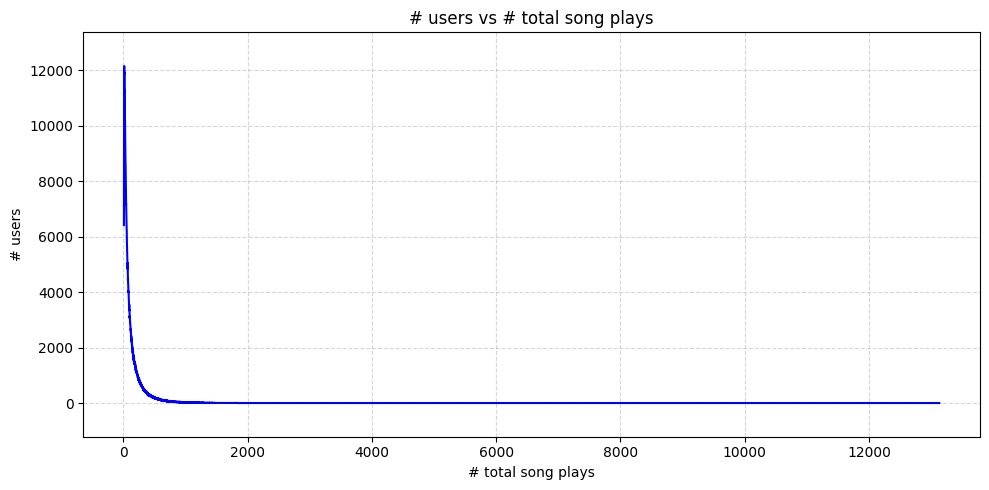

In [65]:
# (d)
temp = (
    triplets_data
    .groupBy(F.col("user_id"))
    .agg(
        F.sum("play_count").cast(DoubleType()).alias("total_song_plays"),
        F.count("song_id").cast(DoubleType()).alias("num_unique_songs")
    )
)

total_song_plays_user_counts = (
    temp
    .groupBy(F.col("total_song_plays"))
    .agg(
        F.count(F.col("user_id")).alias("num_users")
    )
    .repartition(1)
    .orderBy(F.col("total_song_plays"))
)

num_unique_songs_user_counts = (
    temp
    .groupBy(F.col("num_unique_songs"))
    .agg(
        F.count(F.col("user_id")).alias("num_users")
    )
    .repartition(1)
    .orderBy(F.col("num_unique_songs"))
)

total_song_plays_user_counts_local = total_song_plays_user_counts.toPandas()
num_unique_songs_user_counts_local = num_unique_songs_user_counts.toPandas()

display(total_song_plays_user_counts_local)
display(num_unique_songs_user_counts_local)

x = total_song_plays_user_counts_local["total_song_plays"]
y = total_song_plays_user_counts_local["num_users"]

plt.close('all')

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y, '-b')

ax.grid(alpha=0.5, linestyle='--')

ax.margins(0.05, 0.1)

ax.set_title(f"# users vs # total song plays")
ax.set_xlabel('# total song plays')
ax.set_ylabel('# users')

fig.tight_layout()


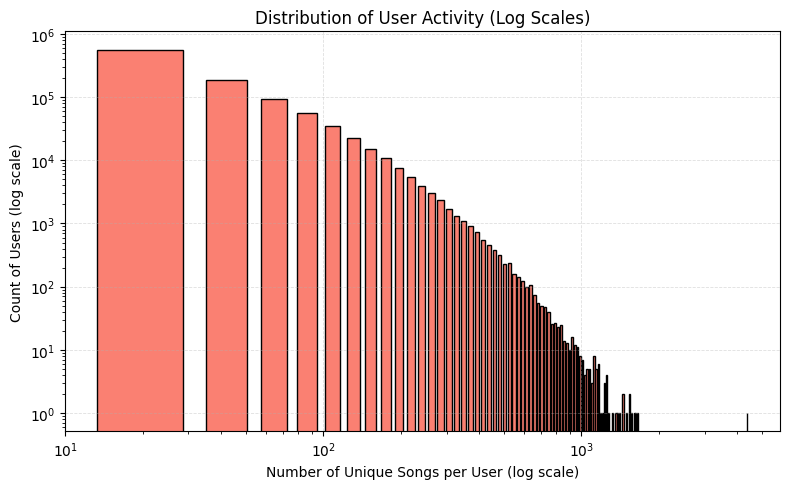

In [72]:
# Count unique songs per user
user_activity = (
    triplets_data
    .groupBy("user_id")
    .agg(F.countDistinct("song_id").alias("unique_song_plays"))
)

# Convert to Pandas for plotting
user_activity_pd = user_activity.toPandas()

# Plot histogram with more spacing between bars
plt.figure(figsize=(8, 5))
plt.hist(
    user_activity_pd["unique_song_plays"],
    bins=200,                         # finer bins
    color='salmon',
    edgecolor='black',
    rwidth=0.7,                       # smaller value = more space between bars
    log=True                          # log scale on y-axis
)
plt.xscale("log")                     # log scale on x-axis
plt.xlabel("Number of Unique Songs per User (log scale)")
plt.ylabel("Count of Users (log scale)")
plt.title("Distribution of User Activity (Log Scales)")
plt.grid(alpha=0.4, linestyle='--', linewidth=0.6)
plt.tight_layout()
plt.show()


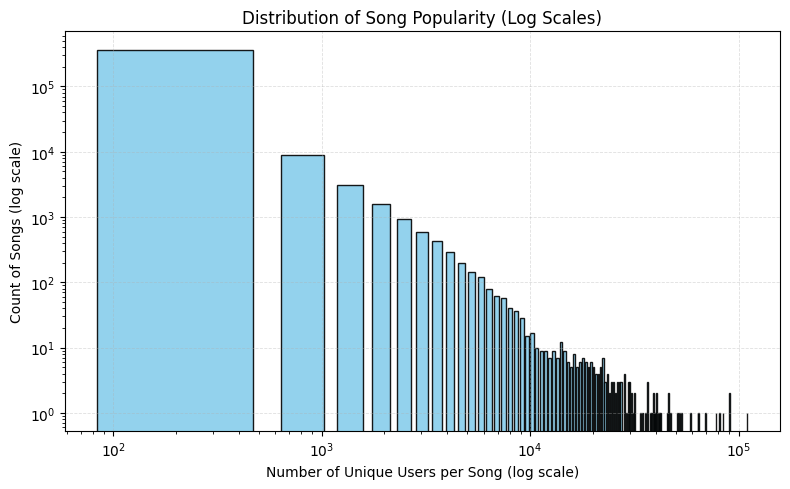

In [73]:

# Count unique users per song
song_popularity = (
    triplets_data
    .groupBy("song_id")
    .agg(F.countDistinct("user_id").alias("unique_user_plays"))
)

# Convert to Pandas for plotting
song_popularity_pd = song_popularity.toPandas()

# Plot histogram with log scales and spacing between bars
plt.figure(figsize=(8, 5))
plt.hist(
    song_popularity_pd["unique_user_plays"],
    bins=200,                         # finer bins for smoother curve
    color='skyblue',
    edgecolor='black',
    rwidth=0.7,                       # more spacing between bars
    log=True,                         # log scale on y-axis
    alpha=0.9                         # slight transparency
)
plt.xscale("log")                     # log scale on x-axis
plt.xlabel("Number of Unique Users per Song (log scale)")
plt.ylabel("Count of Songs (log scale)")
plt.title("Distribution of Song Popularity (Log Scales)")
plt.grid(alpha=0.4, linestyle='--', linewidth=0.6)
plt.tight_layout()
plt.show()

# Q2) 

In [76]:
#from pyspark.sql import functions as F

# Count how many times each song has been played
song_play_counts = (
    triplets_data
    .groupBy("song_id")
    .agg(F.count("user_id").alias("song_play_count"))
)

# Keep only songs with ≥ 20 total plays
popular_songs = song_play_counts.filter(F.col("song_play_count") >= 20)

# Count how many unique songs each user has listened to
user_song_counts = (
    triplets_data
    .groupBy("user_id")
    .agg(F.countDistinct("song_id").alias("user_unique_song_count"))
)

#  Keep only users who have listened to ≥ 20 unique songs
active_users = user_song_counts.filter(F.col("user_unique_song_count") >= 20)

# Filter the original dataset to keep only active users and popular songs
filtered_data = (
    triplets_data
    .join(popular_songs, on="song_id", how="inner")
    .join(active_users, on="user_id", how="inner")
)

# Check size of filtered dataset
print("Original dataset size:", triplets_data.count())
print("Filtered dataset size:", filtered_data.count())
print("Unique users (after filtering):", filtered_data.select("user_id").distinct().count())
print("Unique songs (after filtering):", filtered_data.select("song_id").distinct().count())


Original dataset size: 48373586


Filtered dataset size: 42052531


Unique users (after filtering): 661101


[Stage 4588:=================================================>    (22 + 2) / 24]

Unique songs (after filtering): 161173


In [77]:
# Original counts
orig_users = triplets_data.select("user_id").distinct().count()
orig_songs = triplets_data.select("song_id").distinct().count()

# Filtered counts
filt_users = filtered_data.select("user_id").distinct().count()
filt_songs = filtered_data.select("song_id").distinct().count()

# Excluded counts
excluded_users = orig_users - filt_users
excluded_songs = orig_songs - filt_songs

print(f"Original unique users: {orig_users}")
print(f"Unique users after filtering: {filt_users}")
print(f"Excluded users: {excluded_users}")
print(f"Original unique songs: {orig_songs}")
print(f"Unique songs after filtering: {filt_songs}")
print(f"Excluded songs: {excluded_songs}")


[Stage 4663:===================================================>  (23 + 1) / 24]

Original unique users: 1019318
Unique users after filtering: 661101
Excluded users: 358217
Original unique songs: 384546
Unique songs after filtering: 161173
Excluded songs: 223373


In [78]:
from pyspark.ml.feature import StringIndexer

#Convert user_id (string) to user_index (integer)
user_indexer = StringIndexer(
    inputCol="user_id",
    outputCol="user_index",
    handleInvalid="skip"
)

# Convert song_id (string) to song_index (integer)
song_indexer = StringIndexer(
    inputCol="song_id",
    outputCol="song_index",
    handleInvalid="skip"
)

#  Fit the indexers and transform the dataset
indexed_model = user_indexer.fit(filtered_data)
filtered_data = indexed_model.transform(filtered_data)

indexed_model_song = song_indexer.fit(filtered_data)
filtered_data = indexed_model_song.transform(filtered_data)

# Check the transformed schema
filtered_data.select("user_id", "user_index", "song_id", "song_index").show(10, truncate=False)


25/10/24 13:43:08 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/24 13:43:09 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:43:25 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:43:41 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:44:11 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:44:27 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:44:29 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/24 13:44:29 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:44:48 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:45:03 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:45:33 WARN DAGScheduler: Broadcasting large task binary with size 45.0 MiB
[Stage 4744:>                              

+----------------------------------------+----------+------------------+----------+
|user_id                                 |user_index|song_id           |song_index|
+----------------------------------------+----------+------------------+----------+
|00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e|292640.0  |SOGDQWF12A67AD954F|2468.0    |
|00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e|292640.0  |SOGVKXX12A67ADA0B8|400.0     |
|00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e|292640.0  |SOPWKOX12A8C139D43|2045.0    |
|00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e|292640.0  |SOZVCRW12A67ADA0B7|37.0      |
|00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e|292640.0  |SOIGHWG12A8C136A37|1637.0    |
|00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e|292640.0  |SOPHBRE12A8C142825|1142.0    |
|00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e|292640.0  |SOWRMTT12A8C137064|958.0     |
|00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e|292640.0  |SOYEQLD12AB017C713|1468.0    |
|00004fb90a86beb8bed1e9e328f5d9b6ee7dc03e|292640.0  |SOFXJCS12A58A7DF02|872.

In [80]:
#Split dataset into training (80%) and test (20%)
train_data, test_data = filtered_data.randomSplit([0.8, 0.2], seed=42)

# Ensure all users in test_data also exist in train_data
train_users = train_data.select("user_index").distinct()
train_songs = train_data.select("song_index").distinct()

# Remove users or songs in test set that don’t appear in training set
test_data = (
    test_data.join(train_users, on="user_index", how="inner")
              .join(train_songs, on="song_index", how="inner")
)

# Check sizes
print("Training set size:", train_data.count())
print("Test set size (after filtering):", test_data.count())


25/10/24 13:55:38 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/24 13:55:38 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:55:57 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:56:12 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:56:43 WARN DAGScheduler: Broadcasting large task binary with size 45.0 MiB
                                                                                

Training set size: 33639505


25/10/24 13:57:07 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/24 13:57:08 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:57:08 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/24 13:57:09 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:57:09 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/24 13:57:10 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:57:24 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:57:39 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:57:56 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:58:11 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:58:32 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:58:48 WARN DAGScheduler: Broadc

Test set size (after filtering): 8413026


In [79]:
#  Randomly split the dataset into 80% training and 20% test
train_data, test_data = filtered_data.randomSplit([0.8, 0.2], seed=42)

#  Ensure all users in the test set also exist in the training set
train_users = train_data.select("user_id").distinct()
test_users = test_data.select("user_id").distinct()

# Identify users who are present in the test set but missing from the training set
missing_users = test_users.join(train_users, on="user_id", how="left_anti")

# Move interactions of missing users from test_data to train_data
if missing_users.count() > 0:
    missing_user_interactions = test_data.join(missing_users, on="user_id", how="inner")
    train_data = train_data.union(missing_user_interactions)
    test_data = test_data.subtract(missing_user_interactions)

# Optional check — confirm all test users exist in training
remaining_missing = (
    test_data.select("user_id").distinct()
    .join(train_data.select("user_id").distinct(), on="user_id", how="left_anti")
    .count()
)

print("Users in test set missing from training:", remaining_missing)

#  Print dataset statistics
total_interactions = filtered_data.count()
train_interactions = train_data.count()
test_interactions = test_data.count()

print(f"Total interactions: {total_interactions}")
print(f"Training interactions: {train_interactions} ({train_interactions / total_interactions:.2%})")
print(f"Test interactions: {test_interactions} ({test_interactions / total_interactions:.2%})")


25/10/24 13:45:36 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/24 13:45:36 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:45:37 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/24 13:45:37 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:45:52 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:46:07 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:46:22 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:46:38 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:47:46 WARN DAGScheduler: Broadcasting large task binary with size 45.1 MiB
25/10/24 13:48:31 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/24 13:48:32 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:48:32 WARN DAGScheduler: Broadc

Users in test set missing from training: 0


25/10/24 13:51:23 WARN DAGScheduler: Broadcasting large task binary with size 41.0 MiB
25/10/24 13:51:24 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
25/10/24 13:51:24 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:51:48 WARN DAGScheduler: Broadcasting large task binary with size 41.0 MiB
25/10/24 13:52:03 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:52:33 WARN DAGScheduler: Broadcasting large task binary with size 41.1 MiB
25/10/24 13:52:44 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/24 13:52:44 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:53:00 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:53:15 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 13:53:47 WARN DAGScheduler: Broadcasting large task binary with size 45.0 MiB
25/10/24 13:54:11 WARN DAGScheduler: Broadca

Total interactions: 42052531
Training interactions: 33639505 (79.99%)
Test interactions: 8413026 (20.01%)


In [146]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Use NEW output names
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index_new", handleInvalid="skip")
song_indexer = StringIndexer(inputCol="song_id", outputCol="song_index_new", handleInvalid="skip")

# Fit indexers on full dataset
user_indexer_model = user_indexer.fit(filtered_data)
song_indexer_model = song_indexer.fit(filtered_data)

# Transform train and test
train_indexed = user_indexer_model.transform(train_data)
train_indexed = song_indexer_model.transform(train_indexed)

test_indexed = user_indexer_model.transform(test_data)
test_indexed = song_indexer_model.transform(test_indexed)

# Train ALS
als = ALS(
    userCol="user_index_new",
    itemCol="song_index_new",
    ratingCol="play_count",
    implicitPrefs=True,
    coldStartStrategy="drop",
    rank=10,
    maxIter=15,
    regParam=0.1
)

als_model = als.fit(train_indexed)

# Predictions and evaluation
predictions = als_model.transform(test_indexed)

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="play_count",
    predictionCol="prediction"
)

rmse = evaluator.evaluate(predictions)
print(f"Root Mean Square Error (RMSE) on test data = {rmse:.4f}")


25/10/24 01:04:22 WARN DAGScheduler: Broadcasting large task binary with size 41.0 MiB
25/10/24 01:04:22 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
25/10/24 01:04:22 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 01:04:52 WARN DAGScheduler: Broadcasting large task binary with size 41.0 MiB
25/10/24 01:05:11 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 01:05:29 WARN DAGScheduler: Broadcasting large task binary with size 41.1 MiB
25/10/24 01:05:40 WARN DAGScheduler: Broadcasting large task binary with size 41.0 MiB
25/10/24 01:05:44 WARN DAGScheduler: Broadcasting large task binary with size 41.0 MiB
25/10/24 01:05:45 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
25/10/24 01:05:45 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/24 01:06:14 WARN DAGScheduler: Broadcasting large task binary with size 41.0 MiB
25/10/24 01:06:32 WARN DAGScheduler: Broadcas

Root Mean Square Error (RMSE) on test data = 6.6486


In [142]:
# Select a few sample users from the test set
sample_users = test_indexed.select("user_index_new").distinct().limit(5)

# Generate top 10 song recommendations for each selected user
user_recommendations = als_model.recommendForUserSubset(sample_users, 10)

# Show recommendations
user_recommendations.show(truncate=False)


25/10/23 23:18:28 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/23 23:18:28 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:18:55 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:19:13 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:19:33 WARN DAGScheduler: Broadcasting large task binary with size 89.1 MiB
25/10/23 23:19:56 WARN DAGScheduler: Broadcasting large task binary with size 89.1 MiB
25/10/23 23:19:58 WARN DAGScheduler: Broadcasting large task binary with size 90.1 MiB
25/10/23 23:20:17 WARN DAGScheduler: Broadcasting large task binary with size 90.1 MiB
[Stage 6157:>                                                       (0 + 1) / 1]

+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_index_new|recommendations                                                                                                                                                                                 |
+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|354410        |[{24, 0.03102675}, {52, 0.028785242}, {60, 0.027392764}, {76, 0.026671097}, {48, 0.025896579}, {194, 0.024601962}, {95, 0.024429763}, {154, 0.024287224}, {112, 0.024196357}, {40, 0.024143593}]|
|226580        |[{731, 0.11695569}, {2329, 0.11098397}, {194, 0.10144707}, {2191, 0.09816836}, {773, 0.09671964}, {1655, 0.0962339}, {78, 0.09517274}, {271, 0.0

In [143]:
# Compare recommendations with actual songs played
for row in user_recommendations.collect():
    user_id = row["user_index_new"]
    recommended_songs = [r["song_index_new"] for r in row["recommendations"]]

    actual_songs = (
        test_indexed.filter(test_indexed["user_index_new"] == user_id)
        .select("song_index_new")
        .rdd.flatMap(lambda x: x)
        .collect()
    )

    print(f"\nUser {user_id}:")
    print(f"  ▶ Recommended songs: {recommended_songs}")
    print(f"  ▶ Actually played:   {actual_songs[:10]}")


25/10/23 23:28:08 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/23 23:28:08 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:28:33 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:28:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_13591_9 !
25/10/23 23:28:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_13591_7 !
25/10/23 23:28:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_13591_2 !
25/10/23 23:28:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_13596_1 !
25/10/23 23:28:48 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_13596_4 !
25/10/23 23:28:49 WARN TaskSetManager: Lost task 0.0 in stage 6163.0 (TID 64342) (10.244.14.32 executor 6): FetchFailed(null, shuffleId=1121, mapIndex=-1, mapId=-1, reduceId=0, message=
org.apache.spark.shuffle.MetadataFetchFailedException: Missing an output 


User 382947:
  ▶ Recommended songs: [0, 26, 7, 3, 6, 32, 17, 34, 2, 10]
  ▶ Actually played:   [31.0, 3015.0, 2237.0, 4918.0, 2192.0, 12184.0]


25/10/23 23:37:21 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/23 23:37:22 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:37:48 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:38:06 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:38:30 WARN DAGScheduler: Broadcasting large task binary with size 89.9 MiB
                                                                                


User 479522:
  ▶ Recommended songs: [14, 2, 4, 38, 30, 9, 5, 8, 27, 110]
  ▶ Actually played:   [207.0, 5493.0, 14976.0, 84485.0, 1210.0, 83896.0]


25/10/23 23:38:52 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/23 23:38:53 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:39:18 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:39:35 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:39:59 WARN DAGScheduler: Broadcasting large task binary with size 89.9 MiB
                                                                                


User 382942:
  ▶ Recommended songs: [731, 2262, 741, 576, 496, 918, 353, 8, 4, 1057]
  ▶ Actually played:   [21015.0, 8.0, 26372.0, 2808.0, 47352.0]


25/10/23 23:40:20 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/23 23:40:20 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:40:45 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:41:03 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:41:26 WARN DAGScheduler: Broadcasting large task binary with size 89.9 MiB
                                                                                


User 438851:
  ▶ Recommended songs: [0, 3, 6, 12, 11, 15, 7, 1, 18, 23]
  ▶ Actually played:   [91.0, 347.0, 14636.0, 11.0, 13575.0]


25/10/23 23:41:47 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/23 23:41:47 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:42:13 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:42:31 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:42:54 WARN DAGScheduler: Broadcasting large task binary with size 89.9 MiB
[Stage 6335:==========================================>           (19 + 5) / 24]


User 354378:
  ▶ Recommended songs: [2, 30, 4, 5, 14, 9, 26, 17, 140, 8]
  ▶ Actually played:   [51805.0, 8150.0, 2693.0, 60652.0, 5.0, 895.0]


In [144]:
from pyspark.sql import functions as F
import math

K = 10

# Generate top-K recommendations for all users in test set
user_recs = als_model.recommendForUserSubset(test_indexed.select("user_index_new").distinct(), K)

# Prepare actual songs played per user (ground truth)
actual_plays = (
    test_indexed.groupBy("user_index_new")
    .agg(F.collect_set("song_index_new").alias("actual_songs"))
)

# Join recommendations with actuals
joined = user_recs.join(actual_plays, on="user_index_new", how="inner")

def precision_at_k(recommended, actual, k=10):
    return len(set(recommended[:k]) & set(actual)) / float(k)

def average_precision(recommended, actual, k=10):
    hits, sum_prec = 0, 0
    for i, r in enumerate(recommended[:k], start=1):
        if r in actual:
            hits += 1
            sum_prec += hits / i
    return sum_prec / min(len(actual), k) if actual else 0

def ndcg(recommended, actual, k=10):
    dcg = sum([(1 / math.log2(i + 2)) if r in actual else 0 for i, r in enumerate(recommended[:k])])
    ideal_dcg = sum([1 / math.log2(i + 2) for i in range(min(len(actual), k))])
    return dcg / ideal_dcg if ideal_dcg > 0 else 0

# Calculate metrics
metrics = joined.rdd.map(lambda row: (
    precision_at_k([r['song_index_new'] for r in row['recommendations']], row['actual_songs'], K),
    average_precision([r['song_index_new'] for r in row['recommendations']], row['actual_songs'], K),
    ndcg([r['song_index_new'] for r in row['recommendations']], row['actual_songs'], K)
))

precision_k, map_k, ndcg_k = metrics.toDF(["Precision@K", "MAP", "NDCG"]).agg(
    F.mean("Precision@K"), F.mean("MAP"), F.mean("NDCG")
).first()

print(f"Precision@{K}: {precision_k:.4f}")
print(f"MAP@{K}:        {map_k:.4f}")
print(f"NDCG@{K}:       {ndcg_k:.4f}")


25/10/23 23:48:19 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:48:20 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/23 23:48:20 WARN DAGScheduler: Broadcasting large task binary with size 35.6 MiB
25/10/23 23:48:20 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:48:35 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:48:36 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:48:52 WARN DAGScheduler: Broadcasting large task binary with size 89.9 MiB
25/10/23 23:49:14 WARN DAGScheduler: Broadcasting large task binary with size 89.9 MiB
25/10/23 23:49:15 WARN DAGScheduler: Broadcasting large task binary with size 89.9 MiB
25/10/23 23:49:17 WARN DAGScheduler: Broadcasting large task binary with size 35.7 MiB
25/10/23 23:49:30 WARN DAGScheduler: Broadcasting large task binary with size 89.9 MiB
25/10/23 23:49:36 WARN DAGScheduler: Broadc

Precision@10: 0.0316
MAP@10:        0.0163
NDCG@10:       0.0400


In [ ]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()